# An implementation of the Ant miner paper for Emotion Recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
df = pd.read_csv("Resources/Ravdess Dataset.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,-675.852,-820.630,-372.474,156.448,0.455,-1.471,68.959,-15.910,217.757,72.966,...,15.036,-3.957,32.880,0.023,-110.137,112.829,20.504,-0.442,17.036,neutral
1,-640.294,-783.178,-358.277,154.661,0.411,-1.555,64.627,-47.438,218.073,76.974,...,12.265,-4.655,30.513,-0.725,-82.309,67.398,13.982,-1.941,19.824,neutral
2,-677.497,-825.274,-375.799,157.171,0.415,-1.537,66.738,-79.028,208.915,73.381,...,22.398,-2.424,37.887,-0.037,-169.023,170.742,30.984,0.124,18.527,neutral
3,-659.499,-809.578,-356.445,164.199,0.455,-1.502,61.317,-70.403,214.674,75.767,...,10.528,1.095,18.721,-0.004,-59.714,50.999,13.634,-0.887,10.296,neutral
4,-698.072,-857.808,-409.923,156.816,0.281,-1.594,70.695,-55.799,221.357,70.646,...,24.944,-2.291,42.875,0.022,-253.151,210.330,35.594,-0.635,28.814,calm


In [3]:
#Level of discretization of the continuous data
bins = 3

(array([364., 845., 231.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

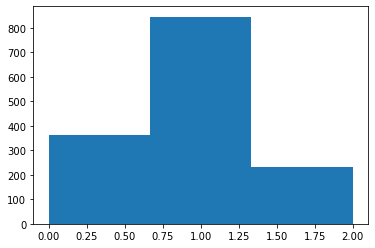

In [4]:
plt.hist(pd.cut(df['f0'], bins=bins, labels=range(bins)), bins = bins)

In [5]:
discreet = pd.DataFrame()

In [6]:
for column in df.drop('class', axis=1).columns:
    discreet[column] = pd.cut(df[column], bins=bins, labels=range(bins))
    #discreet[column] = pd.qcut(df[column], q=bins, labels=range(bins))

In [7]:
discreet['class'] = df['class']
discreet.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f643,f644,f645,f646,f647,f648,f649,f650,f651,class
0,1,1,1,1,2,0,1,2,1,2,...,0,0,0,0,2,0,0,0,0,neutral
1,1,1,1,1,2,0,1,1,1,2,...,0,0,0,0,2,0,0,0,0,neutral
2,1,1,1,1,2,0,1,1,1,2,...,0,1,0,0,2,0,0,0,0,neutral
3,1,1,1,1,2,0,1,1,1,2,...,0,1,0,0,2,0,0,0,0,neutral
4,0,1,1,1,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,0,calm


In [8]:
emotions = discreet['class'].unique()
emotions

array(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust',
       'surprised'], dtype=object)

In [9]:
train, test = np.split(discreet.sample(frac=1), [int(0.75*len(discreet))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
test_len, train_len, total_len

(360, 1080, 1440)

# Entropy values
H will be a matrix of size (bins x features). Computed in a vectorized way to save time (This would take like 10 mins if it was in a for loop, now it takes 10s). <br>
Ok fine I'm looping through the 6 emotions so techhhhnically it's not fully vectorized. Anyway we're computing H only once so I took lite

In [10]:
H = np.zeros((bins, len(train.columns)-1, len(emotions)))

In [13]:
# The most compute intensive step
for e, emotion in enumerate(emotions):
            H[:, :, e] = train.loc[train['class']==emotion].drop('class', axis=1).apply(pd.Series.value_counts).to_numpy()
#H

In [14]:
sums = np.sum(H, axis=2)
#sums

In [15]:
repeated_sums = np.repeat(sums[:, :, np.newaxis], H.shape[2], axis=2)
#repeated_sums[:, :, 1]

In [16]:
P = np.divide(H, repeated_sums, out=np.zeros_like(H), where=repeated_sums!=0)

In [17]:
logP = np.log2(P, out=np.zeros_like(P), where=P>0)
#logP

In [18]:
H = -np.sum(np.multiply(P, logP), axis=2)
#H

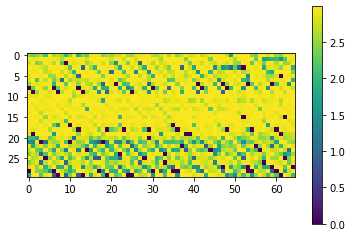

In [21]:
vis = H[:, :-2]
vis = vis.reshape(30,65)
plt.imshow(vis)
plt.colorbar()
plt.show()

In [22]:
features = discreet.drop('class', axis=1).columns
logK = np.log2(len(emotions))

In [48]:
#Hyperparameters
min_coverage = 10
max_uncovered = 10
n_ants = 3000
max_dups = 3

In [49]:
class Rule:
    def __init__(self):
        self.terms = {}
        self.emotion = None
        self.numerosity = 0
        self.coverage = len(train_set)
    
    def match(self, instance):
        for key, value in instance.items():
            if key in self.terms and self.terms[key] != value:
                return False
        return True
    
    def match_set(self):
        dic = {'f' + str(key): val for key, val in self.terms.items()}
        return train_set.loc[np.all(train_set[list(dic)]== pd.Series(dic), axis=1)]
    
    def unmatch_set(self):
        dic = {'f' + str(key): val for key, val in self.terms.items()}
        return train_set.loc[~np.all(train_set[list(dic)]== pd.Series(dic), axis=1)]
    
    def correct_set(self):
        matches = self.match_set()
        return matches.loc[matches['class'] == self.emotion]
    
    def exists(self, feature):
        return feature in self.terms
        
    def coverage_with_new_term(self, term):
        dupTerms = copy.deepcopy(self.terms)
        dupTerms[term['feature']] = term['class']
        dic = {'f' + str(key): val for key, val in dupTerms.items()}
        return len(train_set.loc[np.all(train_set[list(dic)]== pd.Series(dic), axis=1)])
            
    def addTerm(self, term, coverage):
        self.terms[term['feature']] = term['class']
        self.numerosity += 1
        self.coverage = coverage
        
    def quality(self):
        matches = self.match_set()
        unmatches = self.unmatch_set()
        TP = len(matches.loc[matches['class'] == self.emotion])
        FP = len(matches.loc[matches['class'] != self.emotion])
        FN = len(unmatches.loc[unmatches['class'] == self.emotion])
        TN = len(unmatches.loc[unmatches['class'] != self.emotion])
        
        sens = TP / (TP + FN)
        spec = TN / (FP + TN)
        
        return sens * spec
        
    def prune(self):
        pass
        

In [50]:
def normalize_probs(probs):
    return probs / np.sum(probs)

In [51]:
class Ant:
    def __init__(self, index):
        self.index = index
        self.rule = Rule()  
    
    def traverse(self, T):
        x = len(features) - self.rule.numerosity
        Eta = logK - H
        denom = x * np.sum(Eta, axis=0)
        Eta = np.divide(Eta, denom)
        
        Probs = np.multiply(Eta, T)
        denom = x * np.sum(Probs, axis=0)
        Probs = np.divide(Probs, denom)
        
        should_continue = True
        while(should_continue):
            tries = 100
            flattened = Probs.flatten()
            while(tries):
                chosen = int(np.random.choice(len(flattened), 1, p=flattened))
                term = {'feature': chosen % len(features), 'class': chosen // len(features)}
                new_cov = self.rule.coverage_with_new_term(term)
                if new_cov >= min_coverage:
                    self.rule.addTerm(term, new_cov)
                    print("Added " + str(term))
                    
                    Probs[:, term['feature']] = 0
                    Probs = normalize_probs(Probs)
                    
                    should_continue = True
                    break
                tries -= 1
                should_continue = False
                
    def set_emotion(self):
        matches = self.rule.match_set()
        self.rule.emotion = matches['class'].mode()[0]
        

In [52]:
train_set = train

In [53]:
DiscoveredRuleList = []

In [54]:
while len(train_set) > max_uncovered:
    T = np.ones_like(H) * (1 / (bins * len(features)))
    prev_rules = []
    prev_qualities = []
    dups = 0
    for a in range(n_ants):
        ant = Ant(a)
        print("initialized ant " + str(a))
        ant.traverse(T)
        for prev_rule in prev_rules:
            if ant.rule == prev_rule:
                dups += 1
        else:
            ant.set_emotion()
            Q = ant.rule.quality()
            
            mask = np.zeros_like(H)
            mask[list(ant.rule.terms.values()), list(ant.rule.terms)] = 1
            T = T + np.multiply(T, mask) * Q
            T = T / np.sum(T)
            
            if a%20 == 0:
                vis = T[:, :-2]
                vis = vis.reshape(30,65)
                plt.imshow(vis)
                plt.colorbar()
                plt.savefig('Plots/Generation ' + str(len(DiscoveredRuleList)) + ' ant ' + str(a))
                plt.clf()
            
            prev_rules.append(ant.rule)
            prev_qualities.append(Q)
        if dups > max_dups:
            break
            
    imax = np.argmax(prev_qualities)
    DiscoveredRuleList.append(prev_rules[imax])
    corrects = ant.rule.correct_set()
    train_set = pd.concat([train_set, corrects, corrects]).drop_duplicates(keep=False)
        

initialized ant 0
Added {'feature': 631, 'class': 1}
Added {'feature': 618, 'class': 0}
Added {'feature': 438, 'class': 0}
Added {'feature': 122, 'class': 2}
Added {'feature': 297, 'class': 1}
Added {'feature': 600, 'class': 0}
initialized ant 1
Added {'feature': 368, 'class': 1}
Added {'feature': 306, 'class': 0}
Added {'feature': 445, 'class': 1}
Added {'feature': 15, 'class': 0}
Added {'feature': 551, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 602, 'class': 2}
initialized ant 2
Added {'feature': 392, 'class': 0}
Added {'feature': 272, 'class': 0}
Added {'feature': 638, 'class': 1}
Added {'feature': 380, 'class': 1}
initialized ant 3
Added {'feature': 383, 'class': 0}
Added {'feature': 297, 'class': 0}
Added {'feature': 413, 'class': 1}
Added {'feature': 220, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 354, 'class': 1}
Added {'feature': 329, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 2

Added {'feature': 594, 'class': 0}
Added {'feature': 606, 'class': 0}
initialized ant 38
Added {'feature': 478, 'class': 0}
Added {'feature': 422, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 568, 'class': 2}
initialized ant 39
Added {'feature': 167, 'class': 1}
Added {'feature': 28, 'class': 1}
Added {'feature': 19, 'class': 2}
Added {'feature': 571, 'class': 0}
initialized ant 40
Added {'feature': 253, 'class': 1}
Added {'feature': 613, 'class': 2}
Added {'feature': 492, 'class': 0}
initialized ant 41
Added {'feature': 349, 'class': 0}
Added {'feature': 456, 'class': 1}
initialized ant 42
Added {'feature': 449, 'class': 0}
Added {'feature': 438, 'class': 1}
Added {'feature': 437, 'class': 2}
Added {'feature': 583, 'class': 0}
Added {'feature': 524, 'class': 1}
Added {'feature': 440, 'class': 1}
initialized ant 43
Added {'feature': 260, 'class': 2}
Added {'feature': 561, 'class': 0}
Added {'feature': 90, 'class': 1}
Added {'feature': 67, 'class': 1}
initialized ant

initialized ant 77
Added {'feature': 61, 'class': 0}
Added {'feature': 373, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 110, 'class': 0}
Added {'feature': 2, 'class': 2}
initialized ant 78
Added {'feature': 406, 'class': 2}
Added {'feature': 227, 'class': 1}
initialized ant 79
Added {'feature': 456, 'class': 2}
Added {'feature': 613, 'class': 2}
initialized ant 80
Added {'feature': 312, 'class': 2}
Added {'feature': 214, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 637, 'class': 0}
Added {'feature': 35, 'class': 0}
Added {'feature': 200, 'class': 0}
Added {'feature': 560, 'class': 2}
initialized ant 81
Added {'feature': 140, 'class': 2}
Added {'feature': 64, 'class': 0}
Added {'feature': 270, 'class': 1}
initialized ant 82
Added {'feature': 405, 'class': 2}
Added {'feature': 17, 'class': 0}
Added {'feature': 236, 'class': 1}
Added {'feature': 255, 'class': 1}
initialized ant 83
Added {'feature': 20, 'class': 0}

Added {'feature': 524, 'class': 1}
initialized ant 119
Added {'feature': 132, 'class': 2}
Added {'feature': 73, 'class': 1}
Added {'feature': 284, 'class': 0}
Added {'feature': 559, 'class': 0}
initialized ant 120
Added {'feature': 12, 'class': 1}
Added {'feature': 601, 'class': 0}
Added {'feature': 120, 'class': 0}
Added {'feature': 243, 'class': 0}
Added {'feature': 596, 'class': 2}
initialized ant 121
Added {'feature': 161, 'class': 1}
Added {'feature': 535, 'class': 1}
Added {'feature': 381, 'class': 0}
Added {'feature': 28, 'class': 1}
Added {'feature': 586, 'class': 2}
initialized ant 122
Added {'feature': 115, 'class': 0}
Added {'feature': 46, 'class': 0}
Added {'feature': 434, 'class': 1}
initialized ant 123
Added {'feature': 350, 'class': 2}
Added {'feature': 283, 'class': 2}
Added {'feature': 514, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 354, 'class': 1}
initialized ant 124
Added {'feature': 248, 'class': 2}
Added {'fe

Added {'feature': 620, 'class': 2}
Added {'feature': 206, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 584, 'class': 2}
initialized ant 162
Added {'feature': 106, 'class': 2}
Added {'feature': 358, 'class': 0}
initialized ant 163
Added {'feature': 242, 'class': 0}
Added {'feature': 363, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 1, 'class': 2}
Added {'feature': 0, 'class': 2}
Added {'feature': 2, 'class': 2}
Added {'feature': 123, 'class': 0}
Added {'feature': 299, 'class': 0}
Added {'feature': 546, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 584, 'class': 2}
initialized ant 164
Added {'feature': 309, 'class': 2}
Added {'feature': 163, 'class': 1}
Added {'feature': 272, 'class': 0}
Added {'feature': 298, 'class': 1}
Added {'feature': 556, 'class': 0}
Added {'feature': 441, 'class': 0}
initialized ant 165
Added {'feature': 374, 'class': 1}
Added {'feature': 36, 'class': 0}
Added {'feature':

Added {'feature': 599, 'class': 2}
initialized ant 201
Added {'feature': 440, 'class': 0}
Added {'feature': 408, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 140, 'class': 0}
initialized ant 202
Added {'feature': 243, 'class': 0}
Added {'feature': 93, 'class': 2}
Added {'feature': 60, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 517, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 212, 'class': 1}
Added {'feature': 120, 'class': 0}
initialized ant 203
Added {'feature': 140, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 21, 'class': 2}
Added {'feature': 638, 'class': 0}
Added {'feature': 456, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 146, 'class': 0}
initialized ant 204
Added {'feature': 77, 'class': 2}
Added {'feature': 557, 'class': 2}
initialized ant 205
Added {'feature': 649, 'class': 2}
Added {'feature': 89, 'class': 0}
Added {'feature': 42, 'class': 1}
initialized ant 206
Added {'fea

Added {'feature': 453, 'class': 0}
Added {'feature': 70, 'class': 1}
Added {'feature': 539, 'class': 2}
Added {'feature': 630, 'class': 0}
initialized ant 239
Added {'feature': 35, 'class': 2}
Added {'feature': 317, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 538, 'class': 1}
Added {'feature': 154, 'class': 1}
Added {'feature': 240, 'class': 1}
initialized ant 240
Added {'feature': 296, 'class': 2}
Added {'feature': 362, 'class': 1}
Added {'feature': 444, 'class': 0}
initialized ant 241
Added {'feature': 590, 'class': 2}
Added {'feature': 445, 'class': 2}
Added {'feature': 505, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 23, 'class': 0}
Added {'feature': 617, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 447, 'class': 0}
Added {'feature': 611, 'class': 2}
initialized ant 242
Added {'feature': 630, 'class': 1}
Added {'feature': 450, 'class': 0}
Added {'feature': 469, 'class': 1}
Added {'feature': 160, 'class': 2}
Added {'featu

initialized ant 278
Added {'feature': 54, 'class': 0}
Added {'feature': 97, 'class': 0}
Added {'feature': 130, 'class': 1}
Added {'feature': 303, 'class': 1}
Added {'feature': 313, 'class': 2}
Added {'feature': 122, 'class': 1}
Added {'feature': 516, 'class': 0}
initialized ant 279
Added {'feature': 27, 'class': 2}
Added {'feature': 13, 'class': 0}
Added {'feature': 647, 'class': 1}
Added {'feature': 116, 'class': 1}
Added {'feature': 648, 'class': 1}
Added {'feature': 24, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 636, 'class': 2}
initialized ant 280
Added {'feature': 429, 'class': 2}
initialized ant 281
Added {'feature': 274, 'class': 2}
Added {'feature': 640, 'class': 0}
initialized ant 282
Added {'feature': 614, 'class': 1}
Added {'feature': 382, 'class': 0}
Added {'feature': 630, 'class': 1}
initialized ant 283
Added {'feature': 28, 'class': 2}
Added {'feature': 269, 'class': 1}
Added {'feature': 9, 'class': 2}
Added {'featu

Added {'feature': 204, 'class': 1}
initialized ant 318
Added {'feature': 200, 'class': 2}
Added {'feature': 347, 'class': 0}
Added {'feature': 45, 'class': 1}
Added {'feature': 607, 'class': 1}
initialized ant 319
Added {'feature': 480, 'class': 2}
initialized ant 320
Added {'feature': 359, 'class': 2}
initialized ant 321
Added {'feature': 57, 'class': 2}
Added {'feature': 65, 'class': 0}
Added {'feature': 26, 'class': 2}
Added {'feature': 352, 'class': 1}
initialized ant 322
Added {'feature': 517, 'class': 2}
initialized ant 323
Added {'feature': 224, 'class': 2}
Added {'feature': 215, 'class': 0}
Added {'feature': 607, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 406, 'class': 1}
initialized ant 324
Added {'feature': 565, 'class': 2}
Added {'feature': 121, 'class': 1}
Added {'feature': 249, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 281, 'class': 0}
initialized ant 325
Added {'feature': 160, 'class': 0}
Adde

Added {'feature': 31, 'class': 1}
Added {'feature': 582, 'class': 0}
Added {'feature': 477, 'class': 0}
Added {'feature': 156, 'class': 1}
initialized ant 357
Added {'feature': 316, 'class': 1}
Added {'feature': 312, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 139, 'class': 2}
Added {'feature': 587, 'class': 2}
Added {'feature': 240, 'class': 1}
Added {'feature': 272, 'class': 0}
initialized ant 358
Added {'feature': 384, 'class': 2}
Added {'feature': 3, 'class': 0}
Added {'feature': 34, 'class': 0}
Added {'feature': 430, 'class': 1}
Added {'feature': 434, 'class': 1}
initialized ant 359
Added {'feature': 640, 'class': 0}
Added {'feature': 416, 'class': 0}
Added {'feature': 426, 'class': 0}
Added {'feature': 273, 'class': 1}
Added {'feature': 281, 'class': 0}
Added {'feature': 513, 'class': 0}
Added {'feature': 124, 'class': 1}
initialized ant 360
Added {'feature': 81, 'class': 2}
Added {'feature': 315, 'class': 1}
Added {'feature': 155, 'class': 0}
Added {'feature

Added {'feature': 375, 'class': 0}
Added {'feature': 132, 'class': 1}
initialized ant 392
Added {'feature': 103, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 290, 'class': 0}
initialized ant 393
Added {'feature': 437, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 279, 'class': 0}
Added {'feature': 577, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 503, 'class': 2}
Added {'feature': 404, 'class': 1}
initialized ant 394
Added {'feature': 499, 'class': 0}
Added {'feature': 559, 'class': 1}
Added {'feature': 64, 'class': 0}
Added {'feature': 306, 'class': 1}
Added {'feature': 229, 'class': 2}
initialized ant 395
Added {'feature': 141, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 49, 'class': 1}
Added {'feature': 371, 'class': 1}
initialized ant 396
Added {'feature': 576, 'class': 2}
Added {'feature': 266, 'class': 0}
Added {'feature': 30, 'class': 1}
initialized ant 397
Added {'feature': 649, 'class': 2}
Added {'

Added {'feature': 137, 'class': 0}
Added {'feature': 402, 'class': 0}
Added {'feature': 399, 'class': 0}
Added {'feature': 31, 'class': 1}
Added {'feature': 611, 'class': 2}
initialized ant 431
Added {'feature': 207, 'class': 2}
Added {'feature': 254, 'class': 0}
Added {'feature': 257, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 357, 'class': 2}
Added {'feature': 588, 'class': 0}
Added {'feature': 1, 'class': 2}
Added {'feature': 494, 'class': 1}
Added {'feature': 480, 'class': 0}
initialized ant 432
Added {'feature': 643, 'class': 2}
Added {'feature': 397, 'class': 1}
initialized ant 433
Added {'feature': 303, 'class': 2}
Added {'feature': 70, 'class': 2}
initialized ant 434
Added {'feature': 290, 'class': 0}
Added {'feature': 287, 'class': 1}
Added {'feature': 382, 'class': 1}
Added {'feature': 407, 'class': 2}
Added {'feature': 488, 'class': 1}
initialized ant 435
Added {'feature': 362, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 279, 'class

Added {'feature': 354, 'class': 1}
Added {'feature': 312, 'class': 1}
Added {'feature': 468, 'class': 0}
initialized ant 470
Added {'feature': 493, 'class': 2}
Added {'feature': 156, 'class': 1}
Added {'feature': 34, 'class': 2}
initialized ant 471
Added {'feature': 510, 'class': 2}
Added {'feature': 231, 'class': 0}
Added {'feature': 312, 'class': 1}
initialized ant 472
Added {'feature': 605, 'class': 0}
Added {'feature': 283, 'class': 2}
Added {'feature': 327, 'class': 0}
Added {'feature': 408, 'class': 1}
Added {'feature': 192, 'class': 1}
initialized ant 473
Added {'feature': 193, 'class': 1}
Added {'feature': 434, 'class': 0}
Added {'feature': 340, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 162, 'class': 1}
initialized ant 474
Added {'feature': 127, 'class': 0}
Added {'feature': 242, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 72, 'class': 1}
initialized ant 475
Added {'feature': 634, 'class': 2}
Added {

Added {'feature': 498, 'class': 0}
Added {'feature': 255, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 336, 'class': 1}
initialized ant 511
Added {'feature': 348, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 297, 'class': 1}
initialized ant 512
Added {'feature': 389, 'class': 2}
Added {'feature': 216, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 636, 'class': 0}
initialized ant 513
Added {'feature': 407, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 456, 'class': 1}
Added {'feature': 640, 'class': 1}
initialized ant 514
Added {'feature': 339, 'class': 2}
Added {'feature': 628, 'class': 1}
Added {'feature': 313, 'class': 1}
Added {'feature': 112, 'class': 1}
Added {'feature': 254, 'class': 0}
Added {'feature': 131, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 548, 'class': 2}
initialized ant 515
Added {'feature': 202, 'class': 2}
Added {'feature': 646, 'class': 0}
Added {'feature': 373, 'c

Added {'feature': 314, 'class': 0}
Added {'feature': 504, 'class': 0}
initialized ant 546
Added {'feature': 205, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 165, 'class': 1}
initialized ant 547
Added {'feature': 239, 'class': 1}
Added {'feature': 42, 'class': 1}
Added {'feature': 434, 'class': 1}
Added {'feature': 314, 'class': 0}
Added {'feature': 68, 'class': 0}
initialized ant 548
Added {'feature': 207, 'class': 2}
Added {'feature': 648, 'class': 1}
Added {'feature': 592, 'class': 1}
Added {'feature': 462, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 8, 'class': 0}
Added {'feature': 500, 'class': 1}
Added {'feature': 201, 'class': 2}
Added {'feature': 13, 'class': 0}
Added {'feature': 644, 'class': 1}
Added {'feature': 269, 'class': 0}
Added {'feature': 83, 'class': 0}
Added {'feature': 454, 'class': 1}
Added {'feature': 9, 'class': 0}
Added {'feature': 631, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {

initialized ant 581
Added {'feature': 359, 'class': 1}
Added {'feature': 635, 'class': 1}
Added {'feature': 127, 'class': 1}
initialized ant 582
Added {'feature': 479, 'class': 1}
Added {'feature': 34, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 374, 'class': 1}
Added {'feature': 408, 'class': 1}
Added {'feature': 210, 'class': 1}
Added {'feature': 389, 'class': 1}
initialized ant 583
Added {'feature': 382, 'class': 2}
Added {'feature': 641, 'class': 1}
Added {'feature': 631, 'class': 0}
Added {'feature': 194, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 130, 'class': 1}
Added {'feature': 536, 'class': 1}
Added {'feature': 183, 'class': 1}
initialized ant 584
Added {'feature': 199, 'class': 2}
Added {'feature': 193, 'class': 0}
Added {'feature': 410, 'class': 1}
Added {'feature': 310, 'class': 1}
Added {'feature': 423, 'class': 0}
Added {'feature': 521, 'class': 2}
Added {'feature': 352, 'class': 1}
initialized ant 585
Added {'feature': 46, 'clas

Added {'feature': 368, 'class': 2}
initialized ant 619
Added {'feature': 481, 'class': 2}
Added {'feature': 648, 'class': 0}
Added {'feature': 290, 'class': 0}
Added {'feature': 566, 'class': 1}
initialized ant 620
Added {'feature': 141, 'class': 0}
Added {'feature': 464, 'class': 2}
Added {'feature': 50, 'class': 0}
Added {'feature': 580, 'class': 0}
Added {'feature': 297, 'class': 1}
Added {'feature': 389, 'class': 1}
Added {'feature': 596, 'class': 2}
Added {'feature': 549, 'class': 0}
initialized ant 621
Added {'feature': 505, 'class': 2}
Added {'feature': 416, 'class': 1}
Added {'feature': 364, 'class': 0}
Added {'feature': 55, 'class': 1}
Added {'feature': 434, 'class': 2}
Added {'feature': 67, 'class': 1}
initialized ant 622
Added {'feature': 106, 'class': 2}
Added {'feature': 36, 'class': 0}
Added {'feature': 110, 'class': 2}
Added {'feature': 311, 'class': 0}
Added {'feature': 634, 'class': 2}
Added {'feature': 216, 'class': 1}
Added {'feature': 420, 'class': 1}
Added {'featur

initialized ant 651
Added {'feature': 71, 'class': 0}
Added {'feature': 400, 'class': 2}
Added {'feature': 396, 'class': 0}
Added {'feature': 376, 'class': 1}
Added {'feature': 155, 'class': 0}
Added {'feature': 325, 'class': 2}
initialized ant 652
Added {'feature': 366, 'class': 2}
Added {'feature': 255, 'class': 0}
Added {'feature': 437, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 239, 'class': 0}
initialized ant 653
Added {'feature': 413, 'class': 0}
Added {'feature': 638, 'class': 1}
Added {'feature': 546, 'class': 0}
Added {'feature': 116, 'class': 0}
Added {'feature': 389, 'class': 1}
Added {'feature': 240, 'class': 1}
Added {'feature': 545, 'class': 2}
Added {'feature': 358, 'class': 1}
Added {'feature': 160, 'class': 1}
initialized ant 654
Added {'feature': 172, 'class': 0}
Added {'feature': 309, 'class': 1}
Added {'feature': 445, 'class': 1}
Added {'feature': 620, 'class': 2}
Added {'feature': 354, 'class': 1}
initialized ant 655
Added {'feature': 179, 'cl

Added {'feature': 272, 'class': 0}
Added {'feature': 201, 'class': 2}
Added {'feature': 591, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 275, 'class': 0}
Added {'feature': 631, 'class': 0}
Added {'feature': 357, 'class': 2}
Added {'feature': 16, 'class': 1}
initialized ant 685
Added {'feature': 96, 'class': 2}
Added {'feature': 225, 'class': 2}
Added {'feature': 303, 'class': 1}
Added {'feature': 120, 'class': 0}
Added {'feature': 8, 'class': 0}
Added {'feature': 20, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {'feature': 30, 'class': 0}
Added {'feature': 634, 'class': 2}
initialized ant 686
Added {'feature': 193, 'class': 0}
Added {'feature': 54, 'class': 1}
Added {'feature': 324, 'class': 1}
Added {'feature': 496, 'class': 1}
Added {'feature': 101, 'class': 0}
Added {'feature': 500, 'class': 1}
Added {'feature': 516, 'class': 0}
initialized ant 687
Added {'feature': 445, 'class': 2}
Added {'feature': 327, 'class': 1}
Added 

Added {'feature': 54, 'class': 0}
Added {'feature': 85, 'class': 1}
Added {'feature': 290, 'class': 0}
initialized ant 721
Added {'feature': 419, 'class': 0}
Added {'feature': 157, 'class': 1}
initialized ant 722
Added {'feature': 302, 'class': 1}
Added {'feature': 88, 'class': 0}
initialized ant 723
Added {'feature': 515, 'class': 0}
Added {'feature': 354, 'class': 1}
initialized ant 724
Added {'feature': 412, 'class': 0}
Added {'feature': 45, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 173, 'class': 0}
Added {'feature': 136, 'class': 2}
Added {'feature': 290, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 85, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 340, 'class': 1}
Added {'feature': 254, 'class': 0}
initialized ant 725
Added {'feature': 560, 'class': 0}
Added {'feature': 9, 'class': 2}
initialized ant 726
Added {'feature': 643, 'class': 2}
Added {'feature': 359, 'class': 0}
Added {'feat

Added {'feature': 90, 'class': 1}
Added {'feature': 534, 'class': 0}
initialized ant 757
Added {'feature': 349, 'class': 0}
Added {'feature': 434, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 210, 'class': 1}
Added {'feature': 393, 'class': 0}
initialized ant 758
Added {'feature': 620, 'class': 0}
Added {'feature': 40, 'class': 2}
Added {'feature': 599, 'class': 2}
Added {'feature': 360, 'class': 1}
Added {'feature': 341, 'class': 0}
Added {'feature': 596, 'class': 1}
initialized ant 759
Added {'feature': 513, 'class': 1}
Added {'feature': 483, 'class': 0}
Added {'feature': 371, 'class': 1}
Added {'feature': 404, 'class': 1}
initialized ant 760
Added {'feature': 438, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'feature': 244, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 186, 'class': 1}
initialized ant 761
Added {'feature': 361, 'class': 2}
Added {'feature': 121, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 414, 'cla

Added {'feature': 407, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 498, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 631, 'class': 0}
initialized ant 792
Added {'feature': 206, 'class': 2}
Added {'feature': 225, 'class': 2}
Added {'feature': 88, 'class': 2}
Added {'feature': 14, 'class': 0}
Added {'feature': 237, 'class': 2}
Added {'feature': 592, 'class': 1}
Added {'feature': 9, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 648, 'class': 1}
Added {'feature': 634, 'class': 2}
initialized ant 793
Added {'feature': 402, 'class': 2}
Added {'feature': 331, 'class': 1}
Added {'feature': 560, 'class': 2}
Added {'feature': 43, 'class': 1}
Added {'feature': 561, 'class': 0}
Added {'feature': 288, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 366, 'class': 1}
initialized ant 794
Added {'feature': 73, 'class': 0}
Add

Added {'feature': 166, 'class': 1}
Added {'feature': 374, 'class': 1}
initialized ant 826
Added {'feature': 382, 'class': 2}
Added {'feature': 172, 'class': 2}
Added {'feature': 403, 'class': 0}
Added {'feature': 316, 'class': 1}
Added {'feature': 2, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 621, 'class': 0}
Added {'feature': 476, 'class': 2}
Added {'feature': 582, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 516, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 363, 'class': 0}
Added {'feature': 494, 'class': 1}
initialized ant 827
Added {'feature': 410, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 364, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 23, 'class': 0}
Added {'feature': 214, 'class': 1}
initialized ant 828
Added {'feature': 641, 'class': 1}
Added {'feature': 640, 'class': 0}
Added {'feature': 629, 'class': 0}
Added {'feature': 364, 'class': 1}
Added {'feature': 300, 'class': 1

Added {'feature': 612, 'class': 0}
Added {'feature': 429, 'class': 0}
Added {'feature': 440, 'class': 1}
Added {'feature': 484, 'class': 1}
Added {'feature': 377, 'class': 0}
Added {'feature': 534, 'class': 0}
initialized ant 858
Added {'feature': 321, 'class': 2}
Added {'feature': 214, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 401, 'class': 1}
Added {'feature': 408, 'class': 1}
initialized ant 859
Added {'feature': 300, 'class': 0}
Added {'feature': 87, 'class': 0}
Added {'feature': 28, 'class': 0}
initialized ant 860
Added {'feature': 97, 'class': 1}
Added {'feature': 94, 'class': 2}
Added {'feature': 497, 'class': 2}
Added {'feature': 285, 'class': 0}
Added {'feature': 255, 'class': 0}
Added {'feature': 299, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 306, 'class': 1}
Added {'feature': 154, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 190, 'class': 1}
initialized ant 861
Added {'feature': 510, 'class': 2}
Added {'featur

Added {'feature': 2, 'class': 1}
Added {'feature': 288, 'class': 1}
initialized ant 891
Added {'feature': 599, 'class': 1}
Added {'feature': 369, 'class': 1}
Added {'feature': 421, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 288, 'class': 1}
initialized ant 892
Added {'feature': 104, 'class': 1}
Added {'feature': 359, 'class': 1}
Added {'feature': 46, 'class': 0}
Added {'feature': 316, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 101, 'class': 0}
initialized ant 893
Added {'feature': 241, 'class': 0}
Added {'feature': 444, 'class': 2}
Added {'feature': 175, 'class': 2}
initialized ant 894
Added {'feature': 368, 'class': 0}
Added {'feature': 445, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 94, 'class': 1}
Added {'feature': 2, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 85, 'class': 1}
Added {'feature': 584, 'class': 2}
Added {'feature': 497, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature':

Added {'feature': 564, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 111, 'class': 1}
Added {'feature': 281, 'class': 0}
Added {'feature': 23, 'class': 0}
initialized ant 924
Added {'feature': 458, 'class': 0}
Added {'feature': 236, 'class': 1}
Added {'feature': 467, 'class': 1}
Added {'feature': 616, 'class': 1}
Added {'feature': 205, 'class': 1}
initialized ant 925
Added {'feature': 298, 'class': 0}
Added {'feature': 325, 'class': 2}
Added {'feature': 152, 'class': 0}
Added {'feature': 295, 'class': 1}
Added {'feature': 277, 'class': 2}
Added {'feature': 597, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 561, 'class': 0}
initialized ant 926
Added {'feature': 190, 'class': 0}
Added {'feature': 121, 'class': 1}
Added {'feature': 310, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 580, 'class': 0}
initialized ant 927
Added {'feature': 421, 'class': 2}
Added {'feature': 265, 'class': 1}
Added {'feature': 23, 'class': 0}
Added {'feat

Added {'feature': 8, 'class': 0}
Added {'feature': 470, 'class': 1}
Added {'feature': 9, 'class': 0}
Added {'feature': 174, 'class': 1}
Added {'feature': 1, 'class': 2}
Added {'feature': 561, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 549, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 636, 'class': 2}
Added {'feature': 6, 'class': 0}
Added {'feature': 455, 'class': 1}
Added {'feature': 588, 'class': 0}
initialized ant 954
Added {'feature': 636, 'class': 2}
Added {'feature': 413, 'class': 0}
Added {'feature': 553, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 309, 'class': 1}
Added {'feature': 396, 'class': 1}
Added {'feature': 270, 'class': 1}
Added {'feature': 454, 'class': 1}
initialized ant 955
Added {'feature': 295, 'class': 2}
Added {'feature': 560, 'class': 0}
initialized ant 956
Added {'feature': 64, 'class': 0}
Added 

Added {'feature': 46, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 61, 'class': 2}
Added {'feature': 290, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 483, 'class': 0}
initialized ant 986
Added {'feature': 153, 'class': 2}
Added {'feature': 456, 'class': 0}
Added {'feature': 269, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 421, 'class': 0}
Added {'feature': 621, 'class': 0}
Added {'feature': 544, 'class': 1}
Added {'feature': 16, 'class': 1}
initialized ant 987
Added {'feature': 202, 'class': 2}
Added {'feature': 30, 'class': 0}
Added {'feature': 265, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 465, 'class': 0}
Added {'feature': 495, 'class': 0}
initialized ant 988
Added {'feature': 522, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 561, 'class': 0}

Added {'feature': 72, 'class': 1}
Added {'feature': 634, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 139, 'class': 2}
Added {'feature': 619, 'class': 0}
initialized ant 1014
Added {'feature': 295, 'class': 0}
Added {'feature': 70, 'class': 0}
initialized ant 1015
Added {'feature': 12, 'class': 0}
Added {'feature': 424, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 23, 'class': 0}
Added {'feature': 183, 'class': 1}
Added {'feature': 527, 'class': 2}
Added {'feature': 17, 'class': 0}
Added {'feature': 578, 'class': 2}
Added {'feature': 202, 'class': 1}
Added {'feature': 298, 'class': 1}
initialized ant 1016
Added {'feature': 439, 'class': 2}
Added {'feature': 363, 'class': 1}
Added {'feature': 338, 'class': 0}
Added {'feature': 506, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 371, 'class': 1}
initialized ant 1017
Added {'feature': 55, 'class': 0}
Added {'feature': 590, 'class': 2}
Added {'feature': 18, 'class': 0}
Added {'featu

initialized ant 1045
Added {'feature': 407, 'class': 2}
Added {'feature': 410, 'class': 2}
Added {'feature': 69, 'class': 0}
Added {'feature': 389, 'class': 0}
initialized ant 1046
Added {'feature': 645, 'class': 1}
Added {'feature': 154, 'class': 2}
Added {'feature': 354, 'class': 1}
Added {'feature': 615, 'class': 0}
initialized ant 1047
Added {'feature': 351, 'class': 2}
Added {'feature': 634, 'class': 2}
Added {'feature': 224, 'class': 1}
Added {'feature': 357, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 273, 'class': 1}
Added {'feature': 228, 'class': 1}
Added {'feature': 311, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 120, 'class': 0}
Added {'feature': 527, 'class': 2}
Added {'feature': 644, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 235, 'class': 1}
Added {'feature': 500, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 510, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 299, 'clas

Added {'feature': 156, 'class': 1}
Added {'feature': 570, 'class': 0}
Added {'feature': 371, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 276, 'class': 1}
initialized ant 1074
Added {'feature': 424, 'class': 0}
Added {'feature': 219, 'class': 2}
Added {'feature': 98, 'class': 2}
Added {'feature': 77, 'class': 0}
Added {'feature': 472, 'class': 1}
Added {'feature': 227, 'class': 0}
Added {'feature': 150, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 459, 'class': 0}
Added {'feature': 17, 'class': 0}
Added {'feature': 131, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 638, 'class': 0}
Added {'feature': 107, 'class': 0}
Added {'feature': 599, 'class': 2}
Added {'feature': 256, 'class': 1}
Added {'feature': 490, 'class': 0}
initialized ant 1075
Added {'feature': 30, 'class': 0}
Added {'feature': 241, 'class': 0}
Added {'feature': 45, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 58, 'class': 1}
Added {'feature': 3

Added {'feature': 22, 'class': 1}
Added {'feature': 577, 'class': 0}
Added {'feature': 171, 'class': 1}
Added {'feature': 41, 'class': 0}
Added {'feature': 497, 'class': 2}
initialized ant 1108
Added {'feature': 332, 'class': 1}
Added {'feature': 372, 'class': 0}
Added {'feature': 1, 'class': 2}
Added {'feature': 140, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 441, 'class': 0}
initialized ant 1109
Added {'feature': 625, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 170, 'class': 0}
Added {'feature': 450, 'class': 1}
initialized ant 1110
Added {'feature': 516, 'class': 2}
Added {'feature': 599, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 255, 'class': 1}
Added {'feature': 180, 'class': 1}
Added {'feature': 293, 'class': 0}
Added {'feature': 41, 'class': 0}
Added {'feature': 317, 'class': 0}
initialized ant 1111
Added {'feature': 58, 'class': 2}
Added {'feature': 403, 'class': 0}
Added {'feat

Added {'feature': 136, 'class': 2}
Added {'feature': 162, 'class': 1}
initialized ant 1144
Added {'feature': 432, 'class': 0}
Added {'feature': 2, 'class': 0}
Added {'feature': 507, 'class': 0}
Added {'feature': 400, 'class': 2}
Added {'feature': 449, 'class': 1}
Added {'feature': 224, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 524, 'class': 1}
Added {'feature': 570, 'class': 0}
Added {'feature': 611, 'class': 2}
initialized ant 1145
Added {'feature': 159, 'class': 2}
Added {'feature': 333, 'class': 0}
Added {'feature': 325, 'class': 2}
Added {'feature': 529, 'class': 1}
Added {'feature': 290, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 316, 'class': 1}
initialized ant 1146
Added {'feature': 213, 'class': 2}
Added {'feature': 338, 'class': 1}
Added {'feature': 54, 'class': 0}
Added {'feature': 185, 'class': 0}
Added {'feature': 510, 'class'

initialized ant 1176
Added {'feature': 206, 'class': 2}
Added {'feature': 270, 'class': 1}
Added {'feature': 349, 'class': 2}
Added {'feature': 121, 'class': 1}
Added {'feature': 325, 'class': 1}
initialized ant 1177
Added {'feature': 557, 'class': 2}
Added {'feature': 25, 'class': 0}
Added {'feature': 458, 'class': 0}
Added {'feature': 426, 'class': 1}
Added {'feature': 614, 'class': 2}
initialized ant 1178
Added {'feature': 24, 'class': 0}
Added {'feature': 68, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 3, 'class': 0}
initialized ant 1179
Added {'feature': 408, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 67, 'class': 2}
Added {'feature': 18, 'class': 2}
Added {'feature': 440, 'class': 1}
Added {'feature': 376, 'class': 1}
Added {'feature': 571, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 510, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 620, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'featu

Added {'feature': 617, 'class': 2}
initialized ant 1208
Added {'feature': 6, 'class': 0}
Added {'feature': 474, 'class': 1}
Added {'feature': 238, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 334, 'class': 1}
Added {'feature': 303, 'class': 1}
Added {'feature': 1, 'class': 2}
Added {'feature': 440, 'class': 1}
Added {'feature': 618, 'class': 2}
initialized ant 1209
Added {'feature': 348, 'class': 0}
Added {'feature': 321, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 544, 'class': 1}
Added {'feature': 406, 'class': 1}
initialized ant 1210
Added {'feature': 22, 'class': 2}
Added {'feature': 183, 'class': 2}
Added {'feature': 76, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 84, 'class': 0}
Added {'feature': 154, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 177, 'class': 1}
Added {'feature': 110, 'class': 0}
A

Added {'feature': 605, 'class': 2}
Added {'feature': 512, 'class': 1}
Added {'feature': 382, 'class': 1}
initialized ant 1244
Added {'feature': 142, 'class': 2}
Added {'feature': 456, 'class': 1}
Added {'feature': 603, 'class': 0}
Added {'feature': 437, 'class': 1}
Added {'feature': 112, 'class': 1}
Added {'feature': 509, 'class': 2}
Added {'feature': 234, 'class': 1}
Added {'feature': 564, 'class': 0}
initialized ant 1245
Added {'feature': 631, 'class': 1}
Added {'feature': 571, 'class': 2}
Added {'feature': 310, 'class': 1}
Added {'feature': 143, 'class': 0}
Added {'feature': 126, 'class': 2}
initialized ant 1246
Added {'feature': 522, 'class': 2}
initialized ant 1247
Added {'feature': 214, 'class': 2}
Added {'feature': 449, 'class': 1}
Added {'feature': 131, 'class': 0}
Added {'feature': 629, 'class': 2}
initialized ant 1248
Added {'feature': 406, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 231, 'class': 1}
Added {'feature': 157, 'class': 2}
Added {'feature': 32

Added {'feature': 397, 'class': 0}
initialized ant 1277
Added {'feature': 405, 'class': 2}
Added {'feature': 261, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 479, 'class': 2}
Added {'feature': 557, 'class': 2}
Added {'feature': 564, 'class': 0}
initialized ant 1278
Added {'feature': 454, 'class': 0}
Added {'feature': 325, 'class': 2}
Added {'feature': 638, 'class': 0}
Added {'feature': 160, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 541, 'class': 0}
Added {'feature': 94, 'class': 1}
Added {'feature': 441, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 122, 'class': 1}
initialized ant 1279
Added {'feature': 133, 'class': 0}
Added {'feature': 51, 'class': 1}
Added {'feature': 250, 'class': 0}
Added {'feature': 36, 'class': 1}
Added {'feature': 413, 'class': 1}
initialized ant 1280
Added {'feature': 67, 'class': 2}
Added {'fe

Added {'feature': 44, 'class': 1}
Added {'feature': 399, 'class': 0}
Added {'feature': 316, 'class': 1}
Added {'feature': 359, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 95, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 448, 'class': 1}
Added {'feature': 504, 'class': 0}
Added {'feature': 482, 'class': 1}
Added {'feature': 582, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 220, 'class': 1}
initialized ant 1305
Added {'feature': 212, 'class': 2}
Added {'feature': 26, 'class': 1}
Added {'feature': 638, 'class': 0}
initialized ant 1306
Added {'feature': 256, 'class': 0}
Added {'feature': 138, 'class': 1}
Added {'feature': 236, 'class': 0}
initialized ant 1307
Added {'feature': 197, 'class': 2}
Added {'feature': 572, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 166, 'class': 1}
initialized ant 1308
Added {'feature': 186, 'class': 2}
Added {'feature': 625, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'f

Added {'feature': 498, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 225, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 162, 'class': 1}
Added {'feature': 130, 'class': 1}
initialized ant 1339
Added {'feature': 242, 'class': 0}
Added {'feature': 285, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 245, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 120, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 257, 'class': 0}
Added {'feature': 243, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 457, 'class': 1}
Added {'feature': 510, 'class': 0}
Added {'feature': 180, 'class': 1}
Added {'feature': 122, 'class': 0}
Added {'feature': 276, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 630, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 241, 'class': 2}
Added {'feature': 123, 'class': 0}
Added {'feature': 576, 'class': 0}
A

Added {'feature': 531, 'class': 0}
initialized ant 1372
Added {'feature': 350, 'class': 2}
Added {'feature': 576, 'class': 0}
Added {'feature': 486, 'class': 0}
Added {'feature': 374, 'class': 1}
Added {'feature': 301, 'class': 2}
Added {'feature': 605, 'class': 2}
initialized ant 1373
Added {'feature': 478, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 645, 'class': 0}
Added {'feature': 367, 'class': 1}
Added {'feature': 620, 'class': 2}
initialized ant 1374
Added {'feature': 353, 'class': 1}
Added {'feature': 352, 'class': 0}
Added {'feature': 290, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 541, 'class': 0}
initialized ant 1375
Added {'feature': 533, 'class': 2}
Added {'feature': 376, 'class': 2}
Added {'feature': 350, 'class': 1}
Added {'feature': 323, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 242, 'class': 1}
initialized ant 1376
Added {'feature': 56, 'class': 1}
Added {'feature': 113, 'class': 1}
Added {'feature': 285

Added {'feature': 150, 'class': 1}
Added {'feature': 618, 'class': 2}
initialized ant 1404
Added {'feature': 340, 'class': 1}
Added {'feature': 464, 'class': 2}
Added {'feature': 534, 'class': 1}
Added {'feature': 100, 'class': 1}
Added {'feature': 594, 'class': 0}
initialized ant 1405
Added {'feature': 165, 'class': 2}
Added {'feature': 362, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 347, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 616, 'class': 2}
initialized ant 1406
Added {'feature': 575, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 91, 'class': 1}
initialized ant 1407
Added {'feature': 14, 'class': 0}
Added {'feature': 12, 'class': 0}
Added {'feature': 76, 'class': 1}
Added {'feature': 54, 'class': 0}
Added {'feature': 290, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 615, 'class': 0}
Added {'fea

Added {'feature': 499, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 330, 'class': 1}
initialized ant 1433
Added {'feature': 335, 'class': 1}
Added {'feature': 79, 'class': 2}
Added {'feature': 372, 'class': 1}
Added {'feature': 63, 'class': 1}
Added {'feature': 581, 'class': 2}
initialized ant 1434
Added {'feature': 389, 'class': 0}
Added {'feature': 376, 'class': 2}
Added {'feature': 210, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 372, 'class': 1}
initialized ant 1435
Added {'feature': 360, 'class': 2}
Added {'feature': 350, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 444, 'class': 0}
Added {'feature': 44, 'class': 0}
initialized ant 1436
Added {'feature': 489, 'class': 1}
Added {'feature': 408, 'class': 1}
Added {'feature': 389, 'class': 1}
initialized ant 1437
Added {'feature': 243, 'class': 0}
Added {'feature': 98, 'class': 2}
Added {'feature': 201, 'class': 2}
Added {'feature': 166, 'class': 1}
Added {'feature': 120, '

Added {'feature': 326, 'class': 0}
Added {'feature': 328, 'class': 1}
initialized ant 1462
Added {'feature': 69, 'class': 1}
Added {'feature': 360, 'class': 0}
Added {'feature': 330, 'class': 1}
Added {'feature': 154, 'class': 1}
Added {'feature': 440, 'class': 1}
initialized ant 1463
Added {'feature': 457, 'class': 1}
Added {'feature': 307, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 139, 'class': 2}
initialized ant 1464
Added {'feature': 42, 'class': 0}
Added {'feature': 75, 'class': 1}
Added {'feature': 505, 'class': 0}
initialized ant 1465
Added {'feature': 148, 'class': 1}
Added {'feature': 326, 'class': 2}
Added {'feature': 28, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 460, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 121, 'class': 1}
Added {'feature': 603, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 264, 'class': 1}
initialized ant 1466
Added {'feature': 100, '

Added {'feature': 629, 'class': 2}
Added {'feature': 195, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 551, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 108, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 101, 'class': 0}
Added {'feature': 488, 'class': 1}
initialized ant 1498
Added {'feature': 443, 'class': 0}
Added {'feature': 134, 'class': 0}
Added {'feature': 315, 'class': 1}
Added {'feature': 600, 'class': 0}
initialized ant 1499
Added {'feature': 183, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 404, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 456, 'class': 0}
initialized ant 1500
Added {'feature': 266, 'class': 2}
Added {'feature': 354, 'class': 1}
Added {'feature': 491, 'class': 2}
initialized ant 1501
Added {'feature': 414, 'class': 2}
Added {'feature': 304, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 500, 'class': 1}
Added {'feature': 158, 'class': 0}
initia

Added {'feature': 316, 'class': 1}
Added {'feature': 627, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 481, 'class': 1}
Added {'feature': 67, 'class': 1}
Added {'feature': 631, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 25, 'class': 1}
initialized ant 1530
Added {'feature': 224, 'class': 2}
Added {'feature': 371, 'class': 2}
Added {'feature': 504, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 14, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 374, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 30, 'class': 0}
initialized ant 1531
Added {'feature': 330, 'class': 0}
Added {'feature': 46, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 76, 'class': 1}
Added {'feature': 146, 'class': 0}
Added {'feature': 108, 'class': 1}
initialized ant 1532
Added {'feature': 336, 'class': 2

Added {'feature': 300, 'class': 1}
initialized ant 1557
Added {'feature': 57, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 380, 'class': 0}
Added {'feature': 590, 'class': 2}
Added {'feature': 395, 'class': 2}
Added {'feature': 96, 'class': 1}
Added {'feature': 495, 'class': 0}
Added {'feature': 504, 'class': 0}
Added {'feature': 542, 'class': 2}
Added {'feature': 611, 'class': 2}
initialized ant 1558
Added {'feature': 78, 'class': 2}
Added {'feature': 641, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 126, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {'feature': 383, 'class': 2}
Added {'feature': 452, 'class': 1}
initialized ant 1559
Added {'feature': 43, 'class': 2}
Added {'feature': 315, 'class': 2}
Added {'feature': 256, 'class': 1}
Added {'feature': 437, 'class': 2}
Added {'feature': 214, 'class': 1}
Added {'feature': 470, 'class': 1}


initialized ant 1584
Added {'feature': 196, 'class': 1}
Added {'feature': 294, 'class': 0}
Added {'feature': 517, 'class': 0}
Added {'feature': 584, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 527, 'class': 2}
Added {'feature': 423, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 154, 'class': 1}
Added {'feature': 372, 'class': 1}
Added {'feature': 637, 'class': 0}
initialized ant 1585
Added {'feature': 202, 'class': 2}
Added {'feature': 0, 'class': 0}
Added {'feature': 146, 'class': 0}
Added {'feature': 628, 'class': 1}
initialized ant 1586
Added {'feature': 443, 'class': 0}
Added {'feature': 317, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 587, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 474, 'class': 0}
Added {'feature': 191, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 578, 'class': 2}
initialized ant 1587
Added {'feature': 611, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'

Added {'feature': 634, 'class': 2}
Added {'feature': 6, 'class': 0}
Added {'feature': 257, 'class': 0}
Added {'feature': 452, 'class': 1}
initialized ant 1609
Added {'feature': 105, 'class': 2}
Added {'feature': 341, 'class': 0}
Added {'feature': 119, 'class': 0}
Added {'feature': 579, 'class': 0}
Added {'feature': 174, 'class': 1}
Added {'feature': 198, 'class': 1}
Added {'feature': 312, 'class': 1}
Added {'feature': 269, 'class': 0}
Added {'feature': 144, 'class': 1}
Added {'feature': 509, 'class': 2}
initialized ant 1610
Added {'feature': 357, 'class': 2}
Added {'feature': 109, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 6, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 230, 'class': 1}
Added {'feature': 20, 'class': 0}
Added {'feature': 75, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 218, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 1

Added {'feature': 18, 'class': 0}
Added {'feature': 254, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 174, 'class': 1}
Added {'feature': 537, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 394, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 466, 'class': 1}
Added {'feature': 494, 'class': 1}
initialized ant 1636
Added {'feature': 26, 'class': 2}
Added {'feature': 414, 'class': 1}
Added {'feature': 402, 'class': 0}
Added {'feature': 425, 'class': 1}
Added {'feature': 379, 'class': 1}
initialized ant 1637
Added {'feature': 73, 'class': 2}
Added {'feature': 241, 'class': 0}
Added {'feature': 418, 'class': 2}
Added {'feature': 64, 'class': 1}
Added {'feature': 141, 'class': 0}
initialized ant 1638
Added {'feature': 486, 'class': 2}
Added {'feature': 600, 'class': 0}
Added {'feature': 155, 'class': 0}
initialized ant 1639
Added {'feature': 560, 'class': 0}
Added {'fe

Added {'feature': 269, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 634, 'class': 0}
Added {'feature': 365, 'class': 0}
Added {'feature': 283, 'class': 2}
Added {'feature': 630, 'class': 0}
Added {'feature': 206, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 190, 'class': 1}
Added {'feature': 72, 'class': 1}
Added {'feature': 63, 'class': 1}
Added {'feature': 155, 'class': 0}
Added {'feature': 228, 'class': 1}
Added {'feature': 176, 'class': 0}
Added {'feature': 497, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 60, 'class': 1}
Added {'feature': 305, 'class': 0}
Added {'feature': 186, 'class': 1}
initialized ant 1662
Added {'feature': 594, 'class': 0}
Added {'feature': 108, 'class': 2}
Added {'feature': 535, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 316, 'class': 1}
Added {'feature': 606, 'class': 0}
Added {'feature': 534, 'class': 0}
Ad

Added {'feature': 627, 'class': 0}
initialized ant 1690
Added {'feature': 102, 'class': 2}
Added {'feature': 218, 'class': 1}
Added {'feature': 38, 'class': 0}
Added {'feature': 611, 'class': 2}
initialized ant 1691
Added {'feature': 476, 'class': 2}
Added {'feature': 170, 'class': 2}
Added {'feature': 416, 'class': 1}
Added {'feature': 88, 'class': 1}
Added {'feature': 495, 'class': 0}
initialized ant 1692
Added {'feature': 236, 'class': 2}
Added {'feature': 24, 'class': 0}
Added {'feature': 542, 'class': 2}
Added {'feature': 130, 'class': 1}
Added {'feature': 349, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 237, 'class': 2}
initialized ant 1693
Added {'feature': 533, 'class': 0}
Added {'feature': 317, 'class': 0}
Added {'feature': 119, 'class': 0}
Added {'feature': 36, 'class': 1}
Added {'feature': 300, 'class': 1}
initialized ant 1694
Added {'feature': 444, 'class': 2}
Added {'feature': 133, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 300, '

Added {'feature': 494, 'class': 1}
Added {'feature': 474, 'class': 0}
initialized ant 1724
Added {'feature': 352, 'class': 1}
Added {'feature': 15, 'class': 0}
Added {'feature': 298, 'class': 1}
Added {'feature': 418, 'class': 1}
Added {'feature': 24, 'class': 0}
Added {'feature': 422, 'class': 1}
Added {'feature': 258, 'class': 0}
Added {'feature': 288, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 300, 'class': 1}
initialized ant 1725
Added {'feature': 312, 'class': 0}
Added {'feature': 38, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 395, 'class': 2}
Added {'feature': 37, 'class': 1}
Added {'feature': 473, 'class': 2}
Added {'feature': 521, 'class': 2}
Added {'feature': 151, 'class': 2}
Added {'feature': 372, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 463, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 619, 'class': 0}
initialized ant 1726
Added {'feature': 499, 'class':

Added {'feature': 599, 'class': 2}
Added {'feature': 643, 'class': 0}
initialized ant 1748
Added {'feature': 431, 'class': 0}
Added {'feature': 272, 'class': 1}
Added {'feature': 25, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 554, 'class': 2}
initialized ant 1749
Added {'feature': 501, 'class': 2}
initialized ant 1750
Added {'feature': 169, 'class': 2}
Added {'feature': 576, 'class': 2}
Added {'feature': 379, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 354, 'class': 1}
initialized ant 1751
Added {'feature': 142, 'class': 2}
Added {'feature': 121, 'class': 2}
Added {'feature': 408, 'class': 1}
Added {'feature': 203, 'class': 0}
initialized ant 1752
Added {'feature': 125, 'class': 2}
Added {'feature': 458, 'class': 0}
Added {'feature': 497, 'class': 2}
Added {'feature': 605, 'class': 2}
initialized ant 1753
Added {'feature': 274, 'class': 1}
Added {'feature': 576, 'class': 2}
Added {'feature': 19, 'class': 1}
Added {'feature': 398, 'class': 2}
i

Added {'feature': 558, 'class': 0}
Added {'feature': 577, 'class': 0}
Added {'feature': 441, 'class': 0}
Added {'feature': 462, 'class': 0}
Added {'feature': 166, 'class': 1}
initialized ant 1783
Added {'feature': 402, 'class': 2}
Added {'feature': 1, 'class': 0}
Added {'feature': 43, 'class': 2}
Added {'feature': 23, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 31, 'class': 2}
Added {'feature': 317, 'class': 0}
Added {'feature': 88, 'class': 1}
Added {'feature': 306, 'class': 1}
Added {'feature': 0, 'class': 0}
Added {'feature': 122, 'class': 2}
Added {'feature': 241, 'class': 0}
initialized ant 1784
Added {'feature': 74, 'class': 1}
Added {'feature': 263, 'class': 1}
Added {'feature': 255, 'class': 0}
initialized ant 1785
Added {'feature': 367, 'class': 0}
Added {'feature': 21, 'class': 0}
Added {'feature': 242, 'class': 1}
initialized ant 1786
Added {'feature': 351, 'class': 2}
Added {'feature': 81, 'class': 0}
Added {'feature': 415, 'class': 1}
Added {'feature':

Added {'feature': 382, 'class': 0}
Added {'feature': 631, 'class': 0}
Added {'feature': 520, 'class': 1}
Added {'feature': 577, 'class': 0}
initialized ant 1808
Added {'feature': 516, 'class': 1}
Added {'feature': 67, 'class': 2}
Added {'feature': 557, 'class': 2}
Added {'feature': 369, 'class': 0}
Added {'feature': 162, 'class': 1}
initialized ant 1809
Added {'feature': 518, 'class': 2}
Added {'feature': 53, 'class': 0}
Added {'feature': 633, 'class': 1}
Added {'feature': 28, 'class': 0}
Added {'feature': 613, 'class': 0}
Added {'feature': 363, 'class': 2}
Added {'feature': 605, 'class': 2}
initialized ant 1810
Added {'feature': 181, 'class': 0}
Added {'feature': 414, 'class': 0}
Added {'feature': 453, 'class': 0}
initialized ant 1811
Added {'feature': 135, 'class': 2}
Added {'feature': 285, 'class': 0}
Added {'feature': 326, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 603, 'class': 0}
Added {'feature': 593, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'f

Added {'feature': 203, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 486, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 65, 'class': 0}
Added {'feature': 143, 'class': 0}
Added {'feature': 435, 'class': 0}
Added {'feature': 474, 'class': 0}
Added {'feature': 113, 'class': 0}
initialized ant 1834
Added {'feature': 603, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 207, 'class': 0}
Added {'feature': 138, 'class': 2}
Added {'feature': 210, 'class': 1}
Added {'feature': 104, 'class': 0}
Added {'feature': 325, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 306, 'class': 1}
initialized ant 1835
Added {'feature': 86, 'class': 2}
Added {'feature': 303, 'class': 1}
Added {'feature': 414, 'class': 0}
Added {'feature': 345, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'feature': 500, 'class': 1}
Added {'feature': 390, 'class': 1}
Added {'feature': 597, 'class': 0}
Added {'feature': 14, 'class': 0}
Added {'feature'

initialized ant 1856
Added {'feature': 216, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 403, 'class': 0}
Added {'feature': 622, 'class': 1}
Added {'feature': 529, 'class': 1}
Added {'feature': 424, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 131, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 274, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 395, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 586, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 521, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 317, 'class': 0}
initialized ant 1857
Added {'feature': 2, 'class': 2}
Added {'feature

Added {'feature': 272, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 617, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 124, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 308, 'class': 0}
Added {'feature': 546, 'class': 0}
Added {'feature': 590, 'class': 2}
initialized ant 1883
Added {'feature': 74, 'class': 2}
Added {'feature': 76, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 168, 'class': 1}
initialized ant 1884
Added {'feature': 516, 'class': 0}
Added {'feature': 216, 'class': 2}
Added {'feature': 297, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 391, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 344, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 498, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 112, 'class': 1}
Added {'feature

Added {'feature': 328, 'class': 1}
initialized ant 1913
Added {'feature': 408, 'class': 2}
Added {'feature': 570, 'class': 0}
Added {'feature': 8, 'class': 0}
Added {'feature': 43, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 451, 'class': 1}
initialized ant 1914
Added {'feature': 303, 'class': 1}
Added {'feature': 330, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 320, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 401, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 365, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 529, 'class': 1}
Added {'feature': 622, 'class': 1}
Added {'feature': 149, 'class': 0}
initialized ant 1915
Added {'feature': 169, 'class': 0}
Added {'feature': 369, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 348, 'class'

Added {'feature': 630, 'class': 0}
Added {'feature': 461, 'class': 2}
initialized ant 1940
Added {'feature': 95, 'class': 0}
Added {'feature': 398, 'class': 0}
Added {'feature': 637, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 606, 'class': 0}
Added {'feature': 640, 'class': 1}
initialized ant 1941
Added {'feature': 505, 'class': 0}
Added {'feature': 256, 'class': 0}
Added {'feature': 404, 'class': 1}
Added {'feature': 166, 'class': 1}
initialized ant 1942
Added {'feature': 77, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 330, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 348, 'class': 1}
initialized ant 1943
Added {'feature': 590, 'class': 1}
Added {'feature': 70, 'class': 2}
Added {'feature': 630, 'class': 1}
Added {'feature': 230, 'class': 0}
Added {'feature': 521, 'class': 2}
Added {'feature': 59, 'class': 0}
Added {'feature': 617, 'class': 0}
Added {'feature': 497, 'class': 2}
initialize

Added {'feature': 482, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 525, 'class': 0}
Added {'feature': 281, 'class': 0}
initialized ant 1963
Added {'feature': 219, 'class': 2}
Added {'feature': 254, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 357, 'class': 2}
Added {'feature': 649, 'class': 1}
Added {'feature': 345, 'class': 2}
Added {'feature': 608, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 298, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 648, 'class': 1}
Added {'feature': 403, 'class': 0}
Added {'feature': 128, 'class': 0}
Added {'feature': 531, 'class': 0}
Added {'feature': 198, 'class': 1}
Added {'feature': 225, 'class': 2}
Added {'feature': 464, 'class': 1}
Added {'feature': 527, 'class': 2}
Added {'feature': 186, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 483, 'class': 0}
initialized ant 1964
Added {'feature': 452, 'class': 1}
Added {'featu

Added {'feature': 611, 'class': 2}
Added {'feature': 453, 'class': 0}
Added {'feature': 509, 'class': 2}
Added {'feature': 511, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 371, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 70, 'class': 0}
Added {'feature': 215, 'class': 0}
initialized ant 1987
Added {'feature': 385, 'class': 0}
Added {'feature': 43, 'class': 0}
Added {'feature': 358, 'class': 1}
Added {'feature': 302, 'class': 1}
Added {'feature': 486, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 395, 'class': 2}
initialized ant 1988
Added {'feature': 51, 'class': 2}
Added {'feature': 621, 'class': 0}
Added {'feature': 417, 'class': 0}
Added {'feature': 477, 'class': 0}
Added {'feature': 303, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 593, 'class': 2}
Added {'feature': 330, 'class': 1}
Added {'feature': 48, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 610, 'class': 1}
Added {'feature':

Added {'feature': 605, 'class': 2}
initialized ant 2007
Added {'feature': 61, 'class': 0}
Added {'feature': 2, 'class': 2}
Added {'feature': 503, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 326, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 202, 'class': 1}
Added {'feature': 451, 'class': 1}
initialized ant 2008
Added {'feature': 134, 'class': 2}
Added {'feature': 36, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 133, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 596, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 318, 'class': 1}
initialized ant 2009
Added {'feature': 398, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 573, 'class': 0}
initialized ant 2010
Added {'feature': 255, 'class': 0}
Added {'fe

Added {'feature': 150, 'class': 1}
initialized ant 2028
Added {'feature': 182, 'class': 2}
Added {'feature': 564, 'class': 0}
Added {'feature': 404, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 270, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 371, 'class': 1}
Added {'feature': 548, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature': 131, 'class': 0}
Added {'feature': 503, 'class': 2}
Added {'feature': 466, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 565, 'class': 0}
initialized ant 2029
Added {'feature': 425, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 376, 'class': 0}
Added {'feature': 17, 'class': 0}
Added {'feature': 590, 'class': 2}
Added {'feature': 336, 'class': 1}
Added {'feature': 255, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 593, 'class': 2}
Added {'featur

Added {'feature': 395, 'class': 2}
Added {'feature': 358, 'class': 1}
initialized ant 2050
Added {'feature': 158, 'class': 2}
Added {'feature': 331, 'class': 2}
Added {'feature': 211, 'class': 2}
initialized ant 2051
Added {'feature': 82, 'class': 1}
Added {'feature': 511, 'class': 1}
Added {'feature': 34, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 72, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 645, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 651, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 198, 'class': 1}
Added {'feature': 272, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 441, 'class': 0}
Added {'feature': 77, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 137, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 274, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature':

Added {'feature': 87, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 94, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 132, 'class': 1}
Added {'feature': 645, 'class': 0}
Added {'feature': 430, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 497, 'class': 2}
Added {'feature': 299, 'class': 0}
Added {'feature': 110, 'class': 0}
initialized ant 2074
Added {'feature': 43, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 417, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 620, 'class': 2}
initialized ant 2075
Added {'feature': 597, 'class': 1}
initialized ant 2076
Added {'feature': 488, 'class': 1}
Added {'feature': 513, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 303, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 354, 'class': 1}
initialized ant 2077
Added {'feature': 123, 'class': 0}
Added {'feature': 499, 'class': 1}
Added {'f

Added {'feature': 1, 'class': 2}
Added {'feature': 37, 'class': 0}
Added {'feature': 305, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 30, 'class': 0}
Added {'feature': 324, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 162, 'class': 1}
Added {'feature': 237, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 268, 'class': 1}
Added {'feature': 58, 'class': 1}
Added {'feature': 511, 'class': 1}
Added {'feature': 6, 'class': 0}
Added {'feature': 38, 'class': 0}
Added {'feature': 451, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 312, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 190, 'class': 1}
Added {'feature': 464, 'class': 1}
Added {'feature': 222, 'class': 1}
initialized ant 2101
Added {'feature': 313, 'class': 0}
Added {'feature': 121, 'class': 1}
Added {'feature': 63, 'class': 1}
Added {'feature': 456, 'class': 1}
Added {'

Added {'feature': 636, 'class': 2}
Added {'feature': 590, 'class': 2}
Added {'feature': 571, 'class': 0}
Added {'feature': 382, 'class': 2}
Added {'feature': 0, 'class': 2}
Added {'feature': 581, 'class': 2}
Added {'feature': 464, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 101, 'class': 0}
Added {'feature': 284, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 17, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 113, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 615, 'class': 0}
Added {'feature': 484, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 441, 'class': 0}
Added {'feature': 167, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 611, '

Added {'feature': 166, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 132, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 41, 'class': 0}
initialized ant 2137
Added {'feature': 2, 'class': 2}
Added {'feature': 291, 'class': 1}
Added {'feature': 424, 'class': 0}
Added {'feature': 584, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 379, 'class': 0}
Added {'feature': 254, 'class': 0}
Added {'feature': 468, 'class': 0}
Added {'feature': 597, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 608, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature': 620, 'class': 2}
Added {'feature': 146, 'class': 0}
Added {'feature': 300, 'class': 1}
initialized ant 2138
Added {'feature': 94, 'class': 1}
Added {'feature': 487, 'class': 2}
Added {'feature': 285, 'class': 0}
Added {'feature': 71, 'class': 0}
initialized ant 21

initialized ant 2152
Added {'feature': 257, 'class': 1}
Added {'feature': 389, 'class': 1}
Added {'feature': 1, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 520, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 352, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 492, 'class': 0}
Added {'feature': 422, 'class': 1}
Added {'feature': 529, 'class': 1}
Added {'feature': 162, 'class': 1}
Added {'feature': 644, 'class': 1}
initialized ant 2153
Added {'feature': 168, 'class': 2}
Added {'feature': 290, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 67, 'class': 1}
Added {'feature': 196, 'class': 1}
initialized ant 2154
Added {'feature': 181, 'class': 1}
Added {'feature': 44, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 521, 'class': 2}
Added {'feature': 16, 'class': 1}
initialized ant 2155
Added {'feature': 366, 'class': 0}
Added {'fea

Added {'feature': 558, 'class': 0}
Added {'feature': 310, 'class': 1}
initialized ant 2176
Added {'feature': 321, 'class': 2}
Added {'feature': 150, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 393, 'class': 0}
Added {'feature': 583, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 348, 'class': 1}
initialized ant 2177
Added {'feature': 410, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 307, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 407, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 533, 'class': 2}
initialized ant 2178
Added {'feature': 175, 'class': 1}
Added {'feature': 75, 'class': 1}
Added {'feature': 408, 'class': 0}
Added {'feature': 641, 'class': 2}
Added {'feature': 310, 'class': 1}
initialized ant 2179
Added {'feature': 431, 'class': 2}
Added {

Added {'feature': 6, 'class': 0}
Added {'feature': 257, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 13, 'class': 0}
initialized ant 2196
Added {'feature': 480, 'class': 1}
Added {'feature': 487, 'class': 0}
Added {'feature': 350, 'class': 0}
Added {'feature': 589, 'class': 0}
Added {'feature': 315, 'class': 1}
Added {'feature': 197, 'class': 0}
initialized ant 2197
Added {'feature': 410, 'class': 2}
Added {'feature': 73, 'class': 1}
Added {'feature': 46, 'class': 0}
Added {'feature': 631, 'class': 0}
Added {'feature': 444, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 603, 'class': 0}
Added {'feature': 227, 'class': 0}
Added {'feature': 310, 'class': 1}
Added {'feature': 288, 'class': 1}
Added {'feature': 613, 'class': 1}
Added {'feature': 

Added {'feature': 524, 'class': 1}
Added {'feature': 585, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 183, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 538, 'class': 1}
Added {'feature': 497, 'class': 2}
initialized ant 2218
Added {'feature': 225, 'class': 2}
Added {'feature': 649, 'class': 1}
Added {'feature': 104, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 497, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 198, 'class': 1}
Added {'feature': 486, 'class': 0}
Added {'feature': 312, 'class': 1}
Added {'feature': 642, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 306, 'class': 1}
Added {'feature': 488, 'class': 1}
initialized ant 2219
Added {'feature': 127, 'class': 0}
Added {'feature': 558, 'class': 0}
initialized ant 2220
Added {'feature': 491, 'cla

Added {'feature': 311, 'class': 0}
Added {'feature': 373, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 616, 'class': 2}
initialized ant 2239
Added {'feature': 106, 'class': 2}
Added {'feature': 203, 'class': 1}
Added {'feature': 121, 'class': 1}
initialized ant 2240
Added {'feature': 158, 'class': 2}
Added {'feature': 328, 'class': 1}
initialized ant 2241
Added {'feature': 244, 'class': 2}
Added {'feature': 183, 'class': 2}
Added {'feature': 590, 'class': 2}
Added {'feature': 403, 'class': 0}
Added {'feature': 353, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 631, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 154, 'class': 1}
Added {'feature': 515, 'class': 2}
Added {'feature': 581, 'class': 2}
Added {'feature': 300, 'cla

Added {'feature': 328, 'class': 1}
Added {'feature': 206, 'class': 0}
Added {'feature': 132, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 454, 'class': 1}
Added {'feature': 542, 'class': 2}
Added {'feature': 506, 'class': 1}
initialized ant 2264
Added {'feature': 51, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 506, 'class': 1}
Added {'feature': 48, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 299, 'class': 0}
Added {'feature': 294, 'class': 1}
initialized ant 2265
Added {'feature': 294, 'class': 2}
Added {'feature': 42, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 570, 'class': 0}
Added {'feature': 615, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 599, 'class': 2}
Added {'feature': 58, 'class': 1}
Added {'feature': 322, 'class': 1}
Added {'feature': 541, 'class': 0}
Added {'feature': 119, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 5, 'class': 0}
Added {'feature': 9

Added {'feature': 589, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 507, 'class': 0}
Added {'feature': 122, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 6, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 602, 'class': 2}
Added {'feature': 571, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 472, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 137, 'class': 0}
Added {'feature': 512, 'class': 1}
Added {'feature': 581, 'class': 2}
Added {'feature': 479, 'class': 2}
Added {'feature': 455, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 121, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 143, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 1, 'class': 2}
initialized ant 2278
Added {'feature': 7, 'class': 0}
Added {'

Added {'feature': 515, 'class': 2}
Added {'feature': 571, 'class': 0}
Added {'feature': 168, 'class': 0}
Added {'feature': 72, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 377, 'class': 0}
Added {'feature': 259, 'class': 2}
initialized ant 2296
Added {'feature': 320, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 117, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 423, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 528, 'class': 0}
initialized ant 2297
Added {'feature': 257, 'class': 2}
Added {'feature': 452, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 65, 'class': 0}
Added {'feature': 633, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 605, 'class': 2}
initialized ant 2298
Added {'feature': 12, 'class': 2}
Added {'feature': 647, 'class'

Added {'feature': 518, 'class': 1}
initialized ant 2311
Added {'feature': 511, 'class': 0}
Added {'feature': 297, 'class': 0}
Added {'feature': 22, 'class': 2}
Added {'feature': 121, 'class': 2}
Added {'feature': 274, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 458, 'class': 1}
Added {'feature': 175, 'class': 2}
Added {'feature': 278, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 509, 'class': 2}
Added {'feature': 562, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 263, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 612, 'class': 0}
initialized ant 2312
Added {'feature': 391, 'class': 0}
Added {'feature': 511, 'class': 0}
Added {'feature': 596, 'class': 1}
Added {'feature': 427, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 463, 'class': 0}
Added {'feature': 296, 'class': 0}
Added {'featur

Added {'feature': 503, 'class': 2}
Added {'feature': 196, 'class': 1}
Added {'feature': 300, 'class': 1}
initialized ant 2332
Added {'feature': 161, 'class': 1}
Added {'feature': 12, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 447, 'class': 0}
initialized ant 2333
Added {'feature': 445, 'class': 2}
Added {'feature': 72, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 121, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 150, 'class': 1}
Added {'feature': 464, 'class': 1}
initialized ant 2334
Added {'feature': 124, 'class': 0}
Added {'feature': 71, 'class': 0}
Added {'feature': 85, 'class': 1}
Added {'feature': 161, 'class': 0}
Added {'feature': 560, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 628, 'class': 1}
Added {'feature': 496, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 121, 'class':

Added {'feature': 534, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 587, 'class': 2}
initialized ant 2352
Added {'feature': 274, 'class': 1}
Added {'feature': 135, 'class': 2}
Added {'feature': 76, 'class': 1}
Added {'feature': 444, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 133, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 576, 'class': 0}
Added {'feature': 349, 'class': 2}
Added {'feature': 324, 'class': 1}
initialized ant 2353
Added {'feature': 91, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 297, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 278, 'class': 0}
Added {'feature': 303, 'class': 1}
Added {'feature': 502, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 509, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 453, 'class': 0}
initialized ant 2354
Added {'feature': 411, 'class

Added {'feature': 128, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 528, 'class': 0}
initialized ant 2370
Added {'feature': 138, 'class': 2}
Added {'feature': 641, 'class': 1}
Added {'feature': 27, 'class': 2}
Added {'feature': 403, 'class': 0}
Added {'feature': 470, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 393, 'class': 0}
Added {'feature': 541, 'class': 0}
initialized ant 2371
Added {'feature': 287, 'class': 1}
Added {'feature': 374, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 295, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 362, 'class': 1}
Added {'feature': 202, 'class': 1}
initialized ant 2372
Added {'feature': 363, 'class': 0}
Added {'feature': 52, 'class': 1}
Added {'feature': 31, 'class': 1}
Added {'feature': 242, 'class': 1}
Added {'feature': 20, 'class':

Added {'feature': 558, 'class': 0}
Added {'feature': 372, 'class': 1}
Added {'feature': 422, 'class': 1}
Added {'feature': 310, 'class': 1}
initialized ant 2388
Added {'feature': 272, 'class': 2}
Added {'feature': 67, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 422, 'class': 1}
initialized ant 2389
Added {'feature': 207, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {'feature': 503, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 228, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 400, 'class': 0}
Added {'feature': 257, 'class': 0}
Added {'feature': 530, 'class': 1}
Added {'feature': 538, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 330, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 209, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature'

Added {'feature': 589, 'class': 0}
Added {'feature': 17, 'class': 0}
Added {'feature': 536, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 507, 'class': 0}
Added {'feature': 506, 'class': 1}
initialized ant 2408
Added {'feature': 125, 'class': 0}
Added {'feature': 37, 'class': 0}
Added {'feature': 414, 'class': 1}
Added {'feature': 389, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 621, 'class': 0}
initialized ant 2409
Added {'feature': 213, 'class': 2}
Added {'feature': 31, 'class': 0}
Added {'feature': 22, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 30, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 503, 'class': 2}
Added {'feature': 161, 'class': 0}
Added {'feature': 351, 'class': 2}
Added {'feature': 587, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 186, 'class': 1}
Added {'feature': 

Added {'feature': 357, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 160, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 603, 'class': 0}
Added {'feature': 146, 'class': 0}
Added {'feature': 614, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 126, 'class': 2}
initialized ant 2430
Added {'feature': 220, 'class': 0}
Added {'feature': 164, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 95, 'class': 0}
initialized ant 2431
Added {'feature': 198, 'class': 2}
Added {'feature': 469, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'featur

Added {'feature': 488, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 26, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature': 178, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 634, 'class': 2}
Added {'feature': 492, 'class': 0}
initialized ant 2445
Added {'feature': 389, 'class': 2}
Added {'feature': 251, 'class': 0}
Added {'feature': 451, 'class': 1}
Added {'feature': 285, 'class': 0}
Added {'feature': 517, 'class': 0}
Added {'feature': 255, 'class': 0}
Added {'feature': 489, 'class': 0}
Added {'feature': 497, 'class': 2}
Added {'feature': 620, 'class': 2}
Added {'feature': 457, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 603, 'class': 0}
Added {'feature': 549, 'class': 0}
initialized ant 2446
Added {'featur

Added {'feature': 557, 'class': 2}
initialized ant 2464
Added {'feature': 278, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 581, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 478, 'class': 1}
Added {'feature': 497, 'class': 2}
Added {'feature': 194, 'class': 0}
Added {'feature': 540, 'class': 0}
Added {'feature': 542, 'class': 2}
initialized ant 2465
Added {'feature': 316, 'class': 1}
Added {'feature': 575, 'class': 1}
Added {'feature': 37, 'class': 2}
Added {'feature': 206, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 325, 'class': 2}
initialized ant 2466
Added {'feature': 587, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 141, 'class': 1}
Added {'feature': 99, 'class': 0}
Added {'feature': 256, 'class': 1}
Added {'feature': 318, 'class': 1}
Added {'feature': 290, 'class': 0}
Added {'feature': 488, 'class': 1}
initialized ant 2467
Added {'feature': 332, 'class': 2}
Added {'

Added {'feature': 489, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 190, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 597, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 506, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 180, 'class': 1}
initialized ant 2484
Added {'feature': 97, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 8, 'class': 0}
Added {'feature': 584, 'class': 2}
Added {'feature': 564, 'class': 0}
Added {'feature': 171, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 138, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 630, 'class': 0}
Added {'feature': 537, 'class': 0}
Added {'feature': 478, 'class': 1}
Added {'feature': 17, 'class': 0}
initialized ant 2485
Added {'feature':

Added {'feature': 542, 'class': 2}
Added {'feature': 17, 'class': 0}
Added {'feature': 1, 'class': 2}
Added {'feature': 363, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 119, 'class': 0}
Added {'feature': 486, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 2, 'class': 2}
Added {'feature': 335, 'class': 0}
Added {'feature': 515, 'class': 2}
Added {'feature': 625, 'class': 0}
Added {'feature': 587, 'class': 2}
initialized ant 2500
Added {'feature': 596, 'class': 1}
Added {'feature': 559, 'class': 1}
Added {'feature': 372, 'class': 1}
Added {'feature': 418, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 144, 'class': 1}
Added {'feature': 489, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 220, 'class': 1}
initialized ant 2501
Added {'feature': 402, 'class': 0}
Added {'feature': 

Added {'feature': 404, 'class': 1}
Added {'feature': 378, 'class': 2}
Added {'feature': 494, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 215, 'class': 0}
Added {'feature': 541, 'class': 0}
Added {'feature': 336, 'class': 1}
initialized ant 2516
Added {'feature': 109, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 292, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 274, 'class': 1}
Added {'feature': 180, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 144, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 527, 'class': 2}
Added {'feature': 506, 'class': 1}
Added {'feature': 578, 'class': 2}
Added {'feature': 488, 'class': 1}
initialized ant 2517
Added {'feature': 305, 'class': 0}
Added {'feature': 80, 'class': 2}
Added {'feature

Added {'feature': 558, 'class': 0}
Added {'feature': 190, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 504, 'class': 0}
Added {'feature': 488, 'class': 1}
initialized ant 2533
Added {'feature': 565, 'class': 2}
Added {'feature': 159, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 374, 'class': 1}
initialized ant 2534
Added {'feature': 402, 'class': 0}
Added {'feature': 27, 'class': 2}
Added {'feature': 170, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 453, 'class': 0}
initialized ant 2535
Added {'feature': 12, 'class': 0}
Added {'feature': 90, 'class': 2}
Added {'feature': 81, 'class': 2}
Added {'feature': 20, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 634, 'class': 2}
Added {'feature': 427, 'class': 1}
Added {'feature': 641, 'class': 1}
Added {'feature': 480, 'class': 0}

Added {'feature': 94, 'class': 2}
Added {'feature': 455, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'feature': 77, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 186, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 161, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 529, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 364, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 579, 'class': 0}
Added {'feature': 136, 'class': 1}
Added {'feature': 605, 'class': 2}
initialized ant 2549
Added {'feature': 118, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 285, 'class': 0}
Added {'feature': 313, 'class': 2}
Added {'feature': 464, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 316, 'class': 1}
A

Added {'feature': 119, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 551, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 563, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 222, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 593, 'class': 2}
Added {'feature': 352, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 482, 'class': 1}
Added {'feature': 621, 'class': 0}
Added {'feature': 565, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 62

initialized ant 2581
Added {'feature': 127, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 364, 'class': 1}
Added {'feature': 593, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 274, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 190, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 305, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 148, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 565, 'class': 0}
initialized ant 2582
Added {'feature': 635, 'class': 2}
Added {'feature': 113, 'class': 1}
Added {'feature': 219, 'class': 2}
Added {'feature': 270, 'class': 1}
Added {'feature': 383, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 636, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 98, 'class': 2}
Added {'feature': 6, 'class': 0}
Added {'feature': 299, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature'

Added {'feature': 365, 'class': 0}
Added {'feature': 615, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 185, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 16, 'class': 1}
Added {'feature': 631, 'class': 0}
Added {'feature': 257, 'class': 0}
Added {'feature': 333, 'class': 1}
Added {'feature': 310, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 570, 'class': 0}
Added {'feature': 203, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 453, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 194, 'class': 0}
Added {'feature': 599, 'class': 2}
Added {'feature': 274, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 519, 'class': 0}
initialized ant 2593
Added {'feature': 408, 'class': 2}
Added {'feature': 440, 'class': 1}
Added {'feature': 439, 'class': 0}
Added {'feature': 577, 'class': 0}


initialized ant 2607
Added {'feature': 613, 'class': 1}
Added {'feature': 23, 'class': 2}
Added {'feature': 254, 'class': 0}
Added {'feature': 188, 'class': 0}
Added {'feature': 629, 'class': 2}
initialized ant 2608
Added {'feature': 231, 'class': 2}
Added {'feature': 290, 'class': 0}
Added {'feature': 315, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 64, 'class': 1}
Added {'feature': 427, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 470, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 162, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 634, 'class': 2}
Added {'feature': 257, 'class': 0}
Added {'feature': 299, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 521, 'class': 2}
Added {'feature'

Added {'feature': 528, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 264, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 202, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 637, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 485, 'class': 2}
Added {'feature': 527, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 53, 'class': 0}
Added {'feature': 614, 'class': 2}
Added {'feature': 203, 'class': 0}
Added {'feature': 138, 'class': 2}
Added {'feature': 430, 'class': 1}
Added {'feature': 222, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 299, 'class': 0}
Added {'feature': 535, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 581, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 416, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 522,

Added {'feature': 400, 'class': 2}
Added {'feature': 380, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 528, 'class': 0}
initialized ant 2641
Added {'feature': 81, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 251, 'class': 0}
Added {'feature': 317, 'class': 0}
Added {'feature': 335, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 369, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 562, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 148, 'class': 1}
Added {'feature': 372, 'class': 0}
Added {'feature': 500, 'class': 1}
Added {'feature': 52, 'class': 1}
Added {'feature': 9, 'class': 0}
Added {'feature': 571, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 390, 'class': 1}
Adde

Added {'feature': 410, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 545, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 587, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 305, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 306, 'class': 1}
initialized ant 2656
Added {'feature': 192, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 601, 'class': 1}
Added {'feature': 437, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 125, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 338, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 516, 'class': 0}
Added {'feature': 572, 'class': 2}
Added {'feature': 599, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 559, 'class': 0}

Added {'feature': 300, 'class': 1}
initialized ant 2668
Added {'feature': 551, 'class': 0}
Added {'feature': 348, 'class': 1}
initialized ant 2669
Added {'feature': 298, 'class': 0}
Added {'feature': 481, 'class': 0}
Added {'feature': 410, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 313, 'class': 2}
Added {'feature': 463, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 352, 'class': 1}
initialized ant 2670
Added {'feature': 633, 'class': 0}
Added {'feature': 172, 'class': 2}
Added {'feature': 145, 'class': 0}
Added {'feature': 315, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 401, 'class': 1}
initialized ant 2671
Added {'feature': 8, 'class': 0}
Added {'feature': 73, 'class': 0}
Added {'feature': 159, 'class': 0}
Added {'feature': 589, 'class': 0}
Added {'feature': 590, 'class': 2}
Added {'feature': 342, 'class': 1}
Added {'feature': 524, 'class': 1}
Added {'feature': 276, 'class': 1}
Added {'f

Added {'feature': 616, 'class': 2}
Added {'feature': 510, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 581, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 497, 'class': 2}
Added {'feature': 121, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 71, 'class': 0}
Added {'feature': 242, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 316, 'class': 1}
Added {'feature': 474, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 620, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 281, 'class': 0}
Added {'feature': 531, 'class': 0}
Added {'feature': 312, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 587, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 612

Added {'feature': 516, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 242, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 227, 'class': 0}
Added {'feature': 315, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 306, 'class': 1}
Added {'feature': 310, 'class': 1}
Added {'feature': 264, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 143, 'class': 0}
Added {'feature': 312, 'class': 1}
Added {'feature': 432, 'class': 0}
Added {'feature': 272, 'class': 0}
Added {'feature': 210, 'class': 1}
Added {'feature': 369, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 222, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 521

Added {'feature': 192, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 536, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 559, 'class': 0}
Added {'feature': 540, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 577, 'class': 0}
Added {'feature': 198, 'class': 1}
Added {'feature': 507, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 583, 'class': 0}
Added {'feature': 222, 'class': 1}
Added {'feature': 576, 'class': 0}
Added {'feature': 553, 'class': 0}
initialized ant 2710
Added {'feature': 583, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 379, 'class': 2}
Added {'feature': 393, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 611, 'class': 2}
initialized ant 2711
Added {'feature': 415, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 20, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 498, 'class': 0}
Added {'feature

Added {'feature': 470, 'class': 0}
Added {'feature': 162, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 393, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 565, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 512, 'class': 1}
Added {'feature': 474, 'class': 0}
Added {'feature': 369, 'class': 0}
Added {'feature': 509, 'class': 2}
initialized ant 2729
Added {'feature': 125, 'class': 2}
Added {'feature': 444, 'class': 1}
Added {'feature': 108, 'class': 1}
Added {'feature': 459, 'class': 0}
Added {'feature': 167, 'class': 0}
Added {'feature': 358, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 284, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 472, 'class': 1}
Added {'feature': 226, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 122, 'class': 2}
Added {'feature': 320, 'class': 0}

Added {'feature': 50, 'class': 0}
Added {'feature': 57, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 59, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 117, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 162, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 288, 'class': 1}
Added {'feature': 539, 'class': 2}
Added {'feature': 242, 'class': 1}
Added {'feature': 597, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 628, 'class': 1}
Added {'feature': 485, 'class': 2}
Added {'feature': 241, 'class': 1}
Added {'feature': 542, 'class': 2}
Added {'feature': 330, 'class': 1}
initialized ant 2748
Added {'feature': 18, 'class': 0}
Added {'feature': 225, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 178, 'class': 1}
Add

Added {'feature': 156, 'class': 1}
Added {'feature': 527, 'class': 2}
Added {'feature': 276, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 18, 'class': 0}
Added {'feature': 310, 'class': 1}
Added {'feature': 149, 'class': 0}
Added {'feature': 174, 'class': 1}
Added {'feature': 440, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 167, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 466, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 16, 'class': 1}
Added {'feature': 494, 'class': 1}
initialized ant 2762
Added {'feature': 100, 'class': 2}
Added {'feature': 255, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 440, 'class': 1}
Added {'feature': 6, 'class': 0}
Added {'feature': 138, 'class': 2}
Added {'feature': 636, 'class': 2}
Added {'feature': 354, 'class': 1}
Added {'feature': 303, 'class': 1}
Add

Added {'feature': 174, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 162, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 417, 'class': 0}
initialized ant 2773
Added {'feature': 491, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 536, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 330, 'class': 1}
Added {'feature': 101, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 472, 'class': 1}
Added {'feature': 288, 'class': 1}
Added {'feature': 191, 'class': 0}
initialized ant 2774
Added {'feature': 219, 'class': 2}
Added {'feature': 184, 'class': 2}
Added {'feature': 202, 'class': 1}
Added {'feature': 215, 'class': 0}
Added {'feature': 41, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 494, 'class': 1}
Added {'featur

Added {'feature': 156, 'class': 1}
Added {'feature': 352, 'class': 1}
Added {'feature': 234, 'class': 1}
initialized ant 2785
Added {'feature': 224, 'class': 2}
Added {'feature': 33, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 471, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 303, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 486, 'class': 0}
Added {'feature': 67, 'class': 1}
Added {'feature': 192, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 101, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 191, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 482, 'class': 1}
A

Added {'feature': 619, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 487, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 531, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 565, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 599, 'class': 2}
Added {'feature': 202, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 296, 'class': 0}
Added {'feature': 559, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 489, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 119, 'class': 0}
Added {'feature': 597, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 310, 'class': 1}
initialized ant 2799
Added {'feature': 81, 'class': 2}
Added {'feature': 611, 'class': 2}
Added {'feature': 255, 'class': 0}


Added {'feature': 494, 'class': 1}
initialized ant 2811
Added {'feature': 628, 'class': 1}
Added {'feature': 617, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 255, 'class': 2}
Added {'feature': 446, 'class': 0}
Added {'feature': 577, 'class': 1}
Added {'feature': 95, 'class': 0}
Added {'feature': 316, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 292, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 358, 'class': 1}
Added {'feature': 197, 'class': 0}
Added {'feature': 203, 'class': 0}
initialized ant 2812
Added {'feature': 206, 'class': 2}
Added {'feature': 434, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 464, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 564, 'class': 0}
Added {'feature': 132, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature'

Added {'feature': 79, 'class': 1}
Added {'feature': 321, 'class': 1}
Added {'feature': 466, 'class': 1}
Added {'feature': 459, 'class': 0}
initialized ant 2824
Added {'feature': 136, 'class': 0}
Added {'feature': 42, 'class': 2}
Added {'feature': 557, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 369, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 298, 'class': 1}
Added {'feature': 570, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 482, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 559, 'class': 0}
Added {'feature': 571, 'class': 0}
initialized ant 2825
Added {'feature': 379, 'class': 1}
Added {'feature': 183, 'class': 2}
Added {'feature': 310, 'class': 1}
Added {'feature': 252, 'class': 1}
Added {'feature': 220, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature

Added {'feature': 561, 'class': 0}
Added {'feature': 642, 'class': 1}
Added {'feature': 511, 'class': 1}
initialized ant 2837
Added {'feature': 12, 'class': 1}
Added {'feature': 124, 'class': 2}
Added {'feature': 481, 'class': 0}
Added {'feature': 125, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 129, 'class': 0}
Added {'feature': 396, 'class': 0}
Added {'feature': 274, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 475, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 487, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 158, 'class': 0}
Added {'feature': 194, 'class': 0}
Added {'feature': 583, 'class': 0}
Added {'feature': 505, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 338, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 35, 'class': 0}
A

Added {'feature': 298, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 486, 'class': 0}
Added {'feature': 599, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature': 268, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 368, 'class': 1}
Added {'feature': 59, 'class': 0}
Added {'feature': 156, 'class': 1}
initialized ant 2850
Added {'feature': 403, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 446, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 362, 'class': 1}
Added {'feature': 220, 'class': 1}
Added {'feature': 178, 'class': 1}
Added {'feature': 32, 'class': 1}
Added {'feature': 209, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 466, 'class': 1}
Added {'feature': 530, 'class': 1}
initialized ant 2851
Added {'feature

Added {'feature': 456, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 154, 'class': 1}
Added {'feature': 627, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 628, 'class': 1}
Added {'feature': 407, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 477, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 274, 'class': 1}
initialized ant 2861
Added {'feature': 627, 'class': 0}
Added {'feature': 201, 'class': 2}
Added {'feature': 611, 'class': 2}
Added {'feature': 27, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 390, 'class': 1}
Added {'feature': 464, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature': 274, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 166, 'class': 1}


Added {'feature': 162, 'class': 1}
Added {'feature': 352, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 358, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 160, 'class': 1}
Added {'feature': 411, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 565, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 630, 'class': 0}
Added {'feature': 198, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 242, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 559, 'class': 0}
Added {'feature': 154, 'class': 1}
Added {'feature': 299, 'class': 0}
Added {'feature': 408, 'class': 1}
Added {'feature': 628, 'class': 1}
Added {'feature': 498, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 561, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 593, 'class': 2}
Added {'feature': 16

initialized ant 2880
Added {'feature': 310, 'class': 1}
Added {'feature': 28, 'class': 1}
Added {'feature': 314, 'class': 2}
Added {'feature': 581, 'class': 2}
Added {'feature': 214, 'class': 1}
initialized ant 2881
Added {'feature': 57, 'class': 2}
Added {'feature': 112, 'class': 2}
Added {'feature': 478, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 153, 'class': 1}
Added {'feature': 470, 'class': 1}
Added {'feature': 38, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 25, 'class': 1}
Added {'feature': 310, 'class': 1}
Added {'feature': 524, 'class': 1}
Added {'feature': 557, 'class': 2}
Added {'feature': 453, 'class': 0}
Added {'feature': 329, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 544, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 636, 'class': 2}
Added {'feature':

Added {'feature': 294, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 599, 'class': 2}
Added {'feature': 531, 'class': 0}
Added {'feature': 174, 'class': 1}
Added {'feature': 222, 'class': 1}
Added {'feature': 144, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 306, 'class': 1}
initialized ant 2891
Added {'feature': 629, 'class': 2}
Added {'feature': 330, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 112, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 96, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 593, 'class': 2}
Added {'feature': 181, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 202, 'class': 1}


Added {'feature': 528, 'class': 0}
Added {'feature': 310, 'class': 1}
initialized ant 2901
Added {'feature': 79, 'class': 0}
Added {'feature': 441, 'class': 1}
Added {'feature': 352, 'class': 1}
Added {'feature': 192, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature': 464, 'class': 1}
Added {'feature': 288, 'class': 1}
Added {'feature': 222, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 180, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 527, 'class': 2}
Added {'feature': 156, 'class': 1}
Added {'feature': 498, 'class': 0}
Added {'feature': 377, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 587, 'class': 2}
initialized ant 2902
Added {'feature': 629, 'class': 2}
Added {'feature': 314, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 587, 'class': 2}
Added {'feature': 336, 'class': 1}
Added {'featur

Added {'feature': 348, 'class': 1}
Added {'feature': 334, 'class': 1}
Added {'feature': 394, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 453, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 612, 'class': 0}
Added {'feature': 300, 'class': 1}
initialized ant 2911
Added {'feature': 96, 'class': 2}
Added {'feature': 395, 'class': 2}
Added {'feature': 22, 'class': 0}
Added {'feature': 132, 'class': 1}
Added {'feature': 464, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 635, 'class': 2}
Added {'feature': 336, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 53, 'class': 0}
Added {'feature': 8, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 288, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 494, 'class': 1}
Added 

Added {'feature': 615, 'class': 0}
Added {'feature': 636, 'class': 2}
Added {'feature': 629, 'class': 2}
initialized ant 2917
Added {'feature': 535, 'class': 0}
Added {'feature': 60, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 533, 'class': 2}
initialized ant 2918
Added {'feature': 407, 'class': 2}
Added {'feature': 98, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 36, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 230, 'class': 1}
Added {'feature': 27, 'class': 1}
Added {'feature': 6, 'class': 0}
Added {'feature': 483, 'class': 0}
Added {'feature': 506, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 524, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 606, 'class': 0}
Added {'feature': 150, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 132, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 472, 'class': 1}
Added {'feature': 5

Added {'feature': 391, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 290, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 180, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 269, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 482, 'class': 1}
initialized ant 2929
Added {'feature': 364, 'class': 2}
Added {'feature': 39, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 115, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 156, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 406, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 359, 'class': 0}
A

Added {'feature': 416, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 215, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 121, 'class': 1}
Added {'feature': 202, 'class': 1}
initialized ant 2939
Added {'feature': 630, 'class': 0}
Added {'feature': 183, 'class': 2}
Added {'feature': 156, 'class': 1}
Added {'feature': 181, 'class': 2}
Added {'feature': 453, 'class': 0}
Added {'feature': 334, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 422, 'class': 1}
Added {'feature': 214, 'class': 1}
Added {'feature': 445, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 542, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 557, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 619, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 593, 'class': 2}

Added {'feature': 482, 'class': 1}
Added {'feature': 506, 'class': 1}
initialized ant 2947
Added {'feature': 406, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {'feature': 424, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 332, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 324, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 281, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 492, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 204, 'class': 1}
Added {'feature': 571, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 524, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 614, 'class': 2}
Added {'feature': 557, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 510, 'class': 0}
Added {'feature': 581, 'class': 2}
A

Added {'feature': 605, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 308, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 524, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 489, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 611, 'class': 2}
initialized ant 2957
Added {'feature': 133, 'class': 2}
Added {'feature': 368, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 596, 'class': 1}
Added {'feature': 152, 'class': 0}
Added {'feature': 268, 'class': 1}
Added {'feature': 494, 'class': 1}
Added {'feature': 572, 'class': 2}
Added {'feature': 593, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 616, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 597, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 649, 'class': 0}
initialized ant 2958
Added {'feature': 390, 'class': 2}
Added {'featu

Added {'feature': 126, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 18, 'class': 0}
Added {'feature': 124, 'class': 1}
Added {'feature': 166, 'class': 1}
Added {'feature': 541, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 1, 'class': 2}
Added {'feature': 542, 'class': 2}
initialized ant 2967
Added {'feature': 218, 'class': 1}
Added {'feature': 66, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 275, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 467, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 269, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 316, 'class': 1}
initialized ant 2968
Added {'feature': 336, 'class': 2}
Added {'feature': 316, 'class': 1}
Added {'feature':

Added {'feature': 528, 'class': 0}
Added {'feature': 222, 'class': 1}
Added {'feature': 606, 'class': 0}
Added {'feature': 510, 'class': 0}
Added {'feature': 306, 'class': 1}
Added {'feature': 264, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 459, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 497, 'class': 2}
Added {'feature': 336, 'class': 1}
Added {'feature': 525, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 468, 'class': 0}
Added {'feature': 454, 'class': 1}
Added {'feature': 263, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 166, 'class': 1}
Added {'feature': 563, 'class': 2}
Added {'feature': 204, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 637, 'class': 1}
initialized ant 2980
Added {'feature': 67, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 115, 'class': 1}


Added {'feature': 625, 'class': 0}
Added {'feature': 615, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 276, 'class': 1}
Added {'feature': 306, 'class': 1}
Added {'feature': 281, 'class': 0}
Added {'feature': 532, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 512, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 298, 'class': 1}
initialized ant 2990
Added {'feature': 201, 'class': 2}
Added {'feature': 20, 'class': 0}
Added {'feature': 178, 'class': 1}
Added {'feature': 622, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 222, 'class': 1}
Added {'feature': 579, 'class': 0}
Added {'feature': 284, 'class': 0}
Added {'feature': 297, 'class': 1}
Added {'feature': 571, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 581, 'class': 2}
Added {'feature': 510, 'class': 0}
Added {'feature': 630, 'class': 0}
Added {'feature': 625, 'class': 0}


Added {'feature': 154, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 482, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 14, 'class': 0}
Added {'feature': 530, 'class': 1}
Added {'feature': 186, 'class': 1}
initialized ant 2996
Added {'feature': 35, 'class': 2}
Added {'feature': 631, 'class': 0}
Added {'feature': 464, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 290, 'class': 0}
Added {'feature': 498, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 310, 'class': 1}
Added {'feature': 470, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 551, 'class': 2}
Added {'feature': 497, 'class': 2}
Added {'feature': 294, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 459, 'class': 0}
A

Added {'feature': 452, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 434, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 264, 'class': 1}
Added {'feature': 585, 'class': 0}
Added {'feature': 498, 'class': 0}
Added {'feature': 457, 'class': 1}
initialized ant 29
Added {'feature': 22, 'class': 0}
Added {'feature': 395, 'class': 1}
Added {'feature': 241, 'class': 1}
Added {'feature': 296, 'class': 0}
initialized ant 30
Added {'feature': 168, 'class': 2}
Added {'feature': 163, 'class': 2}
initialized ant 31
Added {'feature': 18, 'class': 1}
Added {'feature': 325, 'class': 2}
Added {'feature': 45, 'class': 2}
Added {'feature': 458, 'class': 0}
Added {'feature': 33, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 313, 'class': 2}
Added {'feature': 173, 'class': 0}
initialized ant 32
Added {'feature': 46, 'class': 2}
Added {'feature': 297, 'class': 0}
Added {'feature': 211, 'class': 1}
Added {'feature': 209, 'class': 0}
initialized ant 33


Added {'feature': 614, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 360, 'class': 1}
Added {'feature': 497, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 611, 'class': 2}
Added {'feature': 162, 'class': 1}
initialized ant 69
Added {'feature': 320, 'class': 2}
Added {'feature': 352, 'class': 1}
Added {'feature': 168, 'class': 1}
initialized ant 70
Added {'feature': 352, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 128, 'class': 0}
Added {'feature': 449, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 216, 'class': 1}
Added {'feature': 324, 'class': 1}
Added {'feature': 328, 'class': 1}
initialized ant 71
Added {'feature': 431, 'class': 0}
Added {'feature': 147, 'class': 0}
Added {'feature': 175, 'class': 2}
Added {'feature': 215, 'class': 0}
Added {'feature': 151, 'class': 2}
Added {'feature': 531, 'class': 0}
Added {'feature': 540, 'class': 0

Added {'feature': 271, 'class': 2}
Added {'feature': 538, 'class': 1}
Added {'feature': 508, 'class': 1}
Added {'feature': 396, 'class': 1}
initialized ant 108
Added {'feature': 134, 'class': 2}
Added {'feature': 627, 'class': 0}
Added {'feature': 16, 'class': 1}
Added {'feature': 166, 'class': 1}
initialized ant 109
Added {'feature': 174, 'class': 2}
Added {'feature': 348, 'class': 2}
initialized ant 110
Added {'feature': 384, 'class': 2}
Added {'feature': 279, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 301, 'class': 2}
initialized ant 111
Added {'feature': 41, 'class': 2}
Added {'feature': 266, 'class': 0}
Added {'feature': 132, 'class': 1}
initialized ant 112
Added {'feature': 343, 'class': 2}
Added {'feature': 533, 'class': 0}
Added {'feature': 431, 'class': 2}
Added {'feature': 50, 'class': 0}
initialized ant 113
Added {'feature': 264, 'class': 2}
Added {'feature': 627, 'class': 0}
initialized ant 114
Added {'feature': 80, 'cl

Added {'feature': 76, 'class': 1}
initialized ant 148
Added {'feature': 108, 'class': 2}
Added {'feature': 509, 'class': 2}
Added {'feature': 611, 'class': 2}
Added {'feature': 291, 'class': 0}
Added {'feature': 440, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 294, 'class': 1}
initialized ant 149
Added {'feature': 130, 'class': 0}
Added {'feature': 0, 'class': 1}
Added {'feature': 195, 'class': 0}
Added {'feature': 185, 'class': 0}
Added {'feature': 269, 'class': 0}
initialized ant 150
Added {'feature': 364, 'class': 2}
Added {'feature': 379, 'class': 1}
Added {'feature': 380, 'class': 0}
Added {'feature': 355, 'class': 2}
Added {'feature': 621, 'class': 0}
Added {'feature': 410, 'class': 1}
initialized ant 151
Added {'feature': 249, 'class': 2}
Added {'feature': 406, 'class': 1}
Added {'feature': 556, 'class': 0}
initialized ant 152
Added {'feature': 506, 'class': 0}
Added {'feature': 433, 'class': 1}
Added {'feature': 306, 'class': 1}
Added {'feature': 352, 'clas

Added {'feature': 629, 'class': 2}
Added {'feature': 499, 'class': 1}
Added {'feature': 36, 'class': 1}
Added {'feature': 238, 'class': 1}
Added {'feature': 516, 'class': 0}
initialized ant 188
Added {'feature': 611, 'class': 2}
Added {'feature': 332, 'class': 2}
Added {'feature': 175, 'class': 2}
Added {'feature': 294, 'class': 1}
Added {'feature': 490, 'class': 0}
initialized ant 189
Added {'feature': 383, 'class': 0}
Added {'feature': 79, 'class': 1}
Added {'feature': 451, 'class': 1}
initialized ant 190
Added {'feature': 536, 'class': 0}
Added {'feature': 589, 'class': 1}
initialized ant 191
Added {'feature': 370, 'class': 2}
Added {'feature': 219, 'class': 2}
Added {'feature': 594, 'class': 0}
initialized ant 192
Added {'feature': 349, 'class': 0}
Added {'feature': 58, 'class': 1}
Added {'feature': 564, 'class': 0}
Added {'feature': 67, 'class': 1}
Added {'feature': 461, 'class': 2}
Added {'feature': 220, 'class': 1}
Added {'feature': 306, 'class': 1}
initialized ant 193
Added {'f

Added {'feature': 630, 'class': 1}
initialized ant 236
Added {'feature': 546, 'class': 2}
initialized ant 237
Added {'feature': 432, 'class': 2}
Added {'feature': 405, 'class': 1}
Added {'feature': 402, 'class': 0}
Added {'feature': 424, 'class': 1}
Added {'feature': 202, 'class': 1}
initialized ant 238
Added {'feature': 109, 'class': 2}
Added {'feature': 226, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 522, 'class': 0}
initialized ant 239
Added {'feature': 57, 'class': 2}
Added {'feature': 53, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 120, 'class': 0}
Added {'feature': 445, 'class': 1}
Added {'feature': 162, 'class': 1}
Added {'feature': 420, 'class': 1}
Added {'feature': 17, 'class': 0}
initialized ant 240
Added {'feature': 175, 'class': 2}
Added {'feature': 188, 'class': 2}
Added {'feature': 604, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 524, 'class': 1}
Added {'feature': 375, 'class': 0}
initialized ant 241
Added {'

Added {'feature': 241, 'class': 1}
Added {'feature': 194, 'class': 1}
Added {'feature': 485, 'class': 2}
Added {'feature': 0, 'class': 2}
initialized ant 271
Added {'feature': 49, 'class': 0}
Added {'feature': 366, 'class': 1}
Added {'feature': 582, 'class': 0}
Added {'feature': 354, 'class': 1}
initialized ant 272
Added {'feature': 605, 'class': 0}
Added {'feature': 327, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 371, 'class': 1}
Added {'feature': 318, 'class': 1}
initialized ant 273
Added {'feature': 399, 'class': 1}
Added {'feature': 371, 'class': 1}
Added {'feature': 303, 'class': 1}
Added {'feature': 166, 'class': 1}
initialized ant 274
Added {'feature': 237, 'class': 2}
Added {'feature': 516, 'class': 0}
Added {'feature': 94, 'class': 2}
Added {'feature': 140, 'class': 1}
initialized ant 275
Added {'feature': 211, 'class': 0}
Added {'feature': 316, 'class': 1}
initialized ant 276
Added {'feature': 76, 'class': 0}
Added {'feature': 262, 'class': 0}
Added {'fe

Added {'feature': 21, 'class': 0}
Added {'feature': 379, 'class': 0}
Added {'feature': 159, 'class': 1}
Added {'feature': 531, 'class': 0}
initialized ant 309
Added {'feature': 596, 'class': 2}
Added {'feature': 261, 'class': 2}
Added {'feature': 416, 'class': 1}
Added {'feature': 214, 'class': 1}
initialized ant 310
Added {'feature': 16, 'class': 2}
Added {'feature': 480, 'class': 1}
initialized ant 311
Added {'feature': 211, 'class': 0}
Added {'feature': 163, 'class': 2}
Added {'feature': 315, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 501, 'class': 0}
Added {'feature': 156, 'class': 1}
initialized ant 312
Added {'feature': 205, 'class': 0}
Added {'feature': 280, 'class': 2}
Added {'feature': 500, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 94, 'class': 1}
Added {'feature': 472, 'class': 1}
initialized ant 313
Added {'feature': 109, 'class': 0}
Added {'feature': 205, 'class': 1}
Added {'feature': 373, 'clas

Added {'feature': 130, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 107, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature': 482, 'class': 1}
initialized ant 348
Added {'feature': 15, 'class': 2}
Added {'feature': 266, 'class': 1}
Added {'feature': 145, 'class': 1}
Added {'feature': 527, 'class': 2}
Added {'feature': 512, 'class': 1}
Added {'feature': 342, 'class': 1}
initialized ant 349
Added {'feature': 171, 'class': 0}
Added {'feature': 357, 'class': 2}
Added {'feature': 14, 'class': 0}
initialized ant 350
Added {'feature': 158, 'class': 2}
initialized ant 351
Added {'feature': 63, 'class': 2}
Added {'feature': 26, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 156, 'class': 1}
initialized ant 352
Added {'feature': 242, 'class': 0}
Added {'feature': 430, 'class': 1}
Added {'feature': 376, 'class': 0}
Added {'feature': 474, 'class': 0}
Added {'feature': 241, 'class': 2}
Added {'feature': 122, 'class': 0}
Added {'feature': 123, 'class

Added {'feature': 180, 'class': 1}
Added {'feature': 631, 'class': 0}
Added {'feature': 252, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 496, 'class': 1}
Added {'feature': 501, 'class': 0}
initialized ant 388
Added {'feature': 522, 'class': 2}
initialized ant 389
Added {'feature': 546, 'class': 2}
initialized ant 390
Added {'feature': 312, 'class': 2}
Added {'feature': 310, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 137, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 630, 'class': 0}
initialized ant 391
Added {'feature': 171, 'class': 2}
Added {'feature': 199, 'class': 1}
Added {'feature': 238, 'class': 1}
Added {'feature': 229, 'class': 2}
Added {'feature': 429, 'class': 0}
initialized ant 392
Added {'feature': 546, 'class': 2}
Added {'feature': 306, 'class': 1}
Added {'feature': 156, 'class': 1}
initialized ant 393
Added {'feature': 67, 'class': 0}
Added {'feature': 346, 'class': 0}
Added 

Added {'feature': 363, 'class': 2}
initialized ant 425
Added {'feature': 336, 'class': 2}
Added {'feature': 396, 'class': 0}
Added {'feature': 564, 'class': 0}
Added {'feature': 328, 'class': 1}
initialized ant 426
Added {'feature': 559, 'class': 2}
Added {'feature': 308, 'class': 0}
initialized ant 427
Added {'feature': 7, 'class': 1}
Added {'feature': 135, 'class': 2}
Added {'feature': 46, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 70, 'class': 1}
Added {'feature': 527, 'class': 2}
initialized ant 428
Added {'feature': 364, 'class': 2}
Added {'feature': 437, 'class': 1}
Added {'feature': 135, 'class': 1}
Added {'feature': 642, 'class': 0}
Added {'feature': 160, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 406, 'class': 1}
initialized ant 429
Added {'feature': 612, 'class': 1}
Added {'feature': 420, 'class': 2}
Added {'feature': 25, 'class': 1}
initialized ant 430
Added {'feature': 570, 'class': 1}
Added {'fe

Added {'feature': 558, 'class': 0}
Added {'feature': 14, 'class': 0}
initialized ant 464
Added {'feature': 351, 'class': 2}
Added {'feature': 243, 'class': 0}
Added {'feature': 637, 'class': 1}
Added {'feature': 568, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 517, 'class': 1}
Added {'feature': 2, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 452, 'class': 1}
Added {'feature': 120, 'class': 0}
Added {'feature': 618, 'class': 2}
Added {'feature': 420, 'class': 1}
Added {'feature': 397, 'class': 1}
Added {'feature': 311, 'class': 0}
Added {'feature': 509, 'class': 2}
initialized ant 465
Added {'feature': 448, 'class': 0}
Added {'feature': 449, 'class': 1}
Added {'feature': 439, 'class': 1}
Added {'feature': 78, 'class': 1}
Added {'feature': 77, 'class': 0}
Added {'feature': 287, 'class': 0}
Added {'feature': 30, 'class': 1}
Added {'feature': 456, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 403, 'class': 0}
initialized ant 466
A

Added {'feature': 583, 'class': 0}
Added {'feature': 242, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'feature': 67, 'class': 1}
Added {'feature': 13, 'class': 1}
Added {'feature': 426, 'class': 0}
Added {'feature': 128, 'class': 0}
Added {'feature': 483, 'class': 0}
Added {'feature': 564, 'class': 0}
Added {'feature': 188, 'class': 0}
initialized ant 505
Added {'feature': 104, 'class': 0}
Added {'feature': 516, 'class': 2}
Added {'feature': 186, 'class': 1}
Added {'feature': 337, 'class': 2}
Added {'feature': 498, 'class': 0}
Added {'feature': 158, 'class': 0}
Added {'feature': 239, 'class': 0}
initialized ant 506
Added {'feature': 115, 'class': 1}
Added {'feature': 225, 'class': 2}
Added {'feature': 307, 'class': 1}
initialized ant 507
Added {'feature': 542, 'class': 1}
Added {'feature': 358, 'class': 1}
Added {'feature': 30, 'class': 1}
Added {'feature': 18, 'class': 1}
Added {'feature': 365, 'class': 0}
Added {'feature': 247, 'class': 2}
Added {'feature': 639, 'class': 0}

Added {'feature': 186, 'class': 1}
initialized ant 541
Added {'feature': 379, 'class': 2}
Added {'feature': 618, 'class': 0}
Added {'feature': 431, 'class': 2}
Added {'feature': 289, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 484, 'class': 1}
initialized ant 542
Added {'feature': 328, 'class': 2}
Added {'feature': 397, 'class': 0}
initialized ant 543
Added {'feature': 552, 'class': 1}
Added {'feature': 14, 'class': 0}
Added {'feature': 364, 'class': 1}
Added {'feature': 512, 'class': 1}
Added {'feature': 222, 'class': 1}
initialized ant 544
Added {'feature': 61, 'class': 0}
Added {'feature': 224, 'class': 1}
Added {'feature': 46, 'class': 0}
Added {'feature': 310, 'class': 1}
Added {'feature': 380, 'class': 1}
Added {'feature': 70, 'class': 1}
Added {'feature': 257, 'class': 0}
Added {'feature': 631, 'class': 0}
Added {'feature': 327, 'class': 1}
initialized ant 545
Added {'feature': 207, 'class

Added {'feature': 215, 'class': 0}
initialized ant 577
Added {'feature': 596, 'class': 0}
Added {'feature': 218, 'class': 0}
Added {'feature': 119, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 138, 'class': 2}
initialized ant 578
Added {'feature': 419, 'class': 2}
Added {'feature': 438, 'class': 1}
Added {'feature': 448, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 584, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 414, 'class': 0}
Added {'feature': 150, 'class': 1}
Added {'feature': 456, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 479, 'class': 2}
initialized ant 579
Added {'feature': 370, 'class': 2}
Added {'feature': 638, 'class': 0}
Added {'feature': 172, 'class': 1}
Added {'feature': 422, 'class': 1}
Added {'feature': 12, 'class': 2}
Added {'feature': 439, 'class': 0}
Added {'feature': 166, 'class': 1}
initialized ant 580
Added {'fea

Added {'feature': 285, 'class': 1}
Added {'feature': 215, 'class': 0}
Added {'feature': 554, 'class': 2}
Added {'feature': 584, 'class': 2}
Added {'feature': 506, 'class': 1}
Added {'feature': 281, 'class': 0}
initialized ant 614
Added {'feature': 142, 'class': 2}
Added {'feature': 37, 'class': 0}
Added {'feature': 178, 'class': 1}
Added {'feature': 434, 'class': 1}
Added {'feature': 559, 'class': 0}
Added {'feature': 382, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 511, 'class': 1}
Added {'feature': 355, 'class': 2}
initialized ant 615
Added {'feature': 331, 'class': 0}
Added {'feature': 430, 'class': 1}
Added {'feature': 124, 'class': 1}
initialized ant 616
Added {'feature': 564, 'class': 1}
Added {'feature': 140, 'class': 1}
Added {'feature': 273, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 328, 'class': 1}
initialized ant 617
Added {'feature': 216, 'class': 2}
Added {'feature': 531, 'class': 0}
Added {'fea

Added {'feature': 589, 'class': 0}
Added {'feature': 88, 'class': 1}
Added {'feature': 627, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 18, 'class': 2}
Added {'feature': 397, 'class': 0}
initialized ant 651
Added {'feature': 375, 'class': 2}
Added {'feature': 499, 'class': 0}
Added {'feature': 358, 'class': 1}
initialized ant 652
Added {'feature': 636, 'class': 0}
Added {'feature': 192, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 481, 'class': 0}
Added {'feature': 637, 'class': 0}
Added {'feature': 499, 'class': 0}
initialized ant 653
Added {'feature': 257, 'class': 2}
Added {'feature': 222, 'class': 1}
Added {'feature': 638, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 506, 'class': 1}
Added {'feature': 446, 'class': 1}
initialized ant 654
Added {'feature': 178, 'class': 0}
Added {'feature': 206, 'class': 1}
Added {'feature': 577, 'class': 0}
Added {'feat

Added {'feature': 20, 'class': 2}
Added {'feature': 589, 'class': 0}
Added {'feature': 412, 'class': 2}
Added {'feature': 521, 'class': 2}
Added {'feature': 527, 'class': 2}
Added {'feature': 335, 'class': 0}
Added {'feature': 558, 'class': 0}
initialized ant 688
Added {'feature': 262, 'class': 1}
Added {'feature': 40, 'class': 0}
Added {'feature': 3, 'class': 2}
Added {'feature': 427, 'class': 0}
initialized ant 689
Added {'feature': 180, 'class': 2}
Added {'feature': 63, 'class': 0}
Added {'feature': 445, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 352, 'class': 1}
Added {'feature': 88, 'class': 1}
Added {'feature': 530, 'class': 1}
Added {'feature': 183, 'class': 1}
Added {'feature': 621, 'class': 0}
initialized ant 690
Added {'feature': 255, 'class': 0}
Added {'feature': 345, 'class': 1}
Added {'feature': 157, 'class': 1}
Added {'feature': 30, 'class': 1}
initialized ant 691
Added {'feature': 15, 'class': 2}
Added {'feature': 642, 'class': 1}
Added {'feature': 

Added {'feature': 204, 'class': 1}
initialized ant 721
Added {'feature': 406, 'class': 2}
Added {'feature': 397, 'class': 0}
Added {'feature': 530, 'class': 1}
Added {'feature': 124, 'class': 1}
Added {'feature': 635, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 613, 'class': 1}
Added {'feature': 523, 'class': 1}
Added {'feature': 126, 'class': 2}
Added {'feature': 472, 'class': 1}
initialized ant 722
Added {'feature': 382, 'class': 2}
Added {'feature': 10, 'class': 0}
Added {'feature': 28, 'class': 1}
initialized ant 723
Added {'feature': 456, 'class': 2}
Added {'feature': 421, 'class': 1}
Added {'feature': 438, 'class': 1}
Added {'feature': 372, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 32, 'class': 1}
Added {'feature': 330, 'class': 1}
Added {'feature': 162, 'class': 1}
Added {'feature': 125, 'class': 1}
Added {'feature': 202, 'class': 1}
Added {'feature': 354, 'class': 1

initialized ant 757
Added {'feature': 391, 'class': 2}
Added {'feature': 619, 'class': 2}
Added {'feature': 314, 'class': 1}
Added {'feature': 466, 'class': 0}
initialized ant 758
Added {'feature': 412, 'class': 2}
Added {'feature': 94, 'class': 1}
Added {'feature': 450, 'class': 0}
Added {'feature': 193, 'class': 1}
Added {'feature': 328, 'class': 1}
initialized ant 759
Added {'feature': 616, 'class': 0}
Added {'feature': 485, 'class': 1}
Added {'feature': 383, 'class': 2}
Added {'feature': 403, 'class': 0}
Added {'feature': 259, 'class': 2}
Added {'feature': 293, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 481, 'class': 0}
Added {'feature': 276, 'class': 1}
initialized ant 760
Added {'feature': 44, 'class': 2}
Added {'feature': 38, 'class': 1}
Added {'feature': 410, 'class': 1}
Added {'feature': 413, 'class': 1}
Added {'feature': 21, 'class': 1}
Added {'feature': 307, 'class': 2}
Added {'feature': 466, 'class': 1}
Added {'featur

Added {'feature': 354, 'class': 1}
Added {'feature': 215, 'class': 0}
Added {'feature': 619, 'class': 0}
initialized ant 792
Added {'feature': 132, 'class': 0}
Added {'feature': 395, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 227, 'class': 0}
initialized ant 793
Added {'feature': 644, 'class': 2}
Added {'feature': 124, 'class': 2}
Added {'feature': 19, 'class': 2}
Added {'feature': 69, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 555, 'class': 0}
Added {'feature': 510, 'class': 0}
Added {'feature': 376, 'class': 1}
Added {'feature': 181, 'class': 2}
initialized ant 794
Added {'feature': 475, 'class': 2}
Added {'feature': 587, 'class': 1}
initialized ant 795
Added {'feature': 33, 'class': 2}
Added {'feature': 255, 'class': 0}
Added {'feature': 137, 'class': 0}
Added {'feature': 368, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 88, 'class': 1}
Added {'feature': 486, 'class': 0}
initialized ant 796
Added {'feature': 85, 'class'

Added {'feature': 120, 'class': 0}
Added {'feature': 9, 'class': 0}
Added {'feature': 342, 'class': 1}
Added {'feature': 6, 'class': 0}
Added {'feature': 457, 'class': 1}
Added {'feature': 8, 'class': 0}
Added {'feature': 368, 'class': 1}
Added {'feature': 454, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 1, 'class': 2}
initialized ant 825
Added {'feature': 493, 'class': 2}
Added {'feature': 132, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 166, 'class': 1}
Added {'feature': 513, 'class': 0}
initialized ant 826
Added {'feature': 535, 'class': 0}
Added {'feature': 637, 'class': 1}
Added {'feature': 20, 'class': 0}
Added {'feature': 260, 'class': 0}
initialized ant 827
Added {'feature': 315, 'class': 2}
Added {'feature': 126, 'class': 1}
Added {'feature': 121, 'class': 1}
initialized ant 828
Added {'feature': 150, 'class': 0}
Added {'feature': 97, 'class': 2}
Added {'feature': 1, 'class': 0}
Added {'feature': 42, 'class': 2}
Added {'feature': 470, 

Added {'feature': 236, 'class': 0}
Added {'feature': 358, 'class': 1}
initialized ant 856
Added {'feature': 86, 'class': 2}
Added {'feature': 62, 'class': 0}
Added {'feature': 466, 'class': 1}
initialized ant 857
Added {'feature': 521, 'class': 0}
Added {'feature': 592, 'class': 1}
Added {'feature': 355, 'class': 2}
initialized ant 858
Added {'feature': 330, 'class': 2}
Added {'feature': 601, 'class': 1}
Added {'feature': 371, 'class': 1}
Added {'feature': 487, 'class': 0}
Added {'feature': 173, 'class': 0}
initialized ant 859
Added {'feature': 431, 'class': 0}
Added {'feature': 642, 'class': 1}
Added {'feature': 242, 'class': 1}
initialized ant 860
Added {'feature': 430, 'class': 0}
Added {'feature': 288, 'class': 1}
Added {'feature': 424, 'class': 0}
Added {'feature': 376, 'class': 0}
Added {'feature': 595, 'class': 0}
Added {'feature': 583, 'class': 0}
initialized ant 861
Added {'feature': 424, 'class': 0}
Added {'feature': 297, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {

Added {'feature': 577, 'class': 0}
Added {'feature': 320, 'class': 1}
Added {'feature': 543, 'class': 0}
Added {'feature': 316, 'class': 1}
initialized ant 893
Added {'feature': 190, 'class': 0}
Added {'feature': 4, 'class': 2}
Added {'feature': 356, 'class': 0}
Added {'feature': 313, 'class': 2}
initialized ant 894
Added {'feature': 217, 'class': 0}
Added {'feature': 277, 'class': 2}
Added {'feature': 427, 'class': 1}
Added {'feature': 528, 'class': 0}
initialized ant 895
Added {'feature': 79, 'class': 2}
Added {'feature': 416, 'class': 0}
Added {'feature': 155, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 613, 'class': 0}
Added {'feature': 134, 'class': 0}
Added {'feature': 378, 'class': 2}
Added {'feature': 268, 'class': 1}
Added {'feature': 294, 'class': 1}
initialized ant 896
Added {'feature': 248, 'class': 2}
Added {'feature': 234, 'class': 1}
Added {'feature': 256, 'class': 1}
initialized ant 897
Added {'feature': 445, 'class': 2}
Added {'feature': 276, 'clas

Added {'feature': 124, 'class': 1}
initialized ant 922
Added {'feature': 409, 'class': 2}
Added {'feature': 440, 'class': 1}
Added {'feature': 402, 'class': 1}
Added {'feature': 445, 'class': 1}
Added {'feature': 621, 'class': 0}
initialized ant 923
Added {'feature': 172, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 639, 'class': 0}
Added {'feature': 63, 'class': 1}
Added {'feature': 497, 'class': 2}
initialized ant 924
Added {'feature': 261, 'class': 1}
Added {'feature': 294, 'class': 2}
Added {'feature': 194, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 541, 'class': 0}
Added {'feature': 495, 'class': 0}
Added {'feature': 508, 'class': 1}
Added {'feature': 630, 'class': 0}
initialized ant 925
Added {'feature': 275, 'class': 2}
initialized ant 926
Added {'feature': 173, 'class': 1}
Added {'feature': 422, 'class': 2}
Added {'feature': 367, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 488, 'class': 1}
initialized ant 927
Added 

Added {'feature': 629, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature': 319, 'class': 2}
initialized ant 954
Added {'feature': 225, 'class': 1}
Added {'feature': 384, 'class': 2}
Added {'feature': 443, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 605, 'class': 2}
initialized ant 955
Added {'feature': 611, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 33, 'class': 1}
Added {'feature': 184, 'class': 1}
Added {'feature': 158, 'class': 0}
Added {'feature': 269, 'class': 0}
Added {'feature': 188, 'class': 0}
initialized ant 956
Added {'feature': 513, 'class': 1}
Added {'feature': 60, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 293, 'class': 0}
Added {'feature': 330, 'class': 1}
Added {'feature': 126, 'class': 2}
initialized ant 957
Added {'feature': 45, 'class': 2}
Added {'feature': 385, 'class': 0}
Added {'feature': 58, 'class': 1}
Added {'featur

Added {'feature': 618, 'class': 2}
initialized ant 986
Added {'feature': 192, 'class': 0}
Added {'feature': 94, 'class': 1}
Added {'feature': 371, 'class': 1}
Added {'feature': 145, 'class': 2}
Added {'feature': 558, 'class': 0}
Added {'feature': 544, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 475, 'class': 0}
initialized ant 987
Added {'feature': 441, 'class': 2}
Added {'feature': 168, 'class': 1}
Added {'feature': 551, 'class': 2}
Added {'feature': 352, 'class': 1}
Added {'feature': 88, 'class': 1}
initialized ant 988
Added {'feature': 134, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 474, 'class': 0}
Added {'feature': 348, 'class': 1}
initialized ant 989
Added {'feature': 74, 'class': 2}
Added {'feature': 642, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 270, 'class': 1}
Added {'feature': 527, 'class': 2}
Added {'feature': 293, 'class': 0}
Added {'feature': 222, 'class': 1}
Added {'feature': 113, 'class': 0}
initialized a

Added {'feature': 610, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 606, 'class': 0}
Added {'feature': 336, 'class': 1}
initialized ant 1023
Added {'feature': 134, 'class': 1}
Added {'feature': 333, 'class': 1}
Added {'feature': 254, 'class': 2}
Added {'feature': 303, 'class': 1}
Added {'feature': 267, 'class': 1}
Added {'feature': 534, 'class': 0}
initialized ant 1024
Added {'feature': 365, 'class': 1}
Added {'feature': 297, 'class': 0}
Added {'feature': 138, 'class': 2}
Added {'feature': 178, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 536, 'class': 1}
Added {'feature': 186, 'class': 1}
initialized ant 1025
Added {'feature': 481, 'class': 2}
Added {'feature': 458, 'class': 1}
Added {'feature': 58, 'class': 1}
Added {'feature': 191, 'class': 0}
Added {'feature': 330, 'class': 1}
Added {'feature': 590, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 186, 'clas

Added {'feature': 512, 'class': 1}
initialized ant 1061
Added {'feature': 616, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 404, 'class': 1}
Added {'feature': 72, 'class': 1}
Added {'feature': 280, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 638, 'class': 0}
Added {'feature': 451, 'class': 1}
initialized ant 1062
Added {'feature': 214, 'class': 0}
Added {'feature': 276, 'class': 0}
Added {'feature': 15, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 629, 'class': 2}
initialized ant 1063
Added {'feature': 633, 'class': 1}
Added {'feature': 415, 'class': 2}
initialized ant 1064
Added {'feature': 223, 'class': 0}
initialized ant 1065
Added {'feature': 134, 'class': 2}
Added {'feature': 195, 'class': 1}
Added {'feature': 32, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 179, 'class': 0}
Added {'feature': 281, 

Added {'feature': 618, 'class': 2}
Added {'feature': 28, 'class': 0}
Added {'feature': 2, 'class': 2}
Added {'feature': 303, 'class': 1}
Added {'feature': 651, 'class': 0}
Added {'feature': 470, 'class': 1}
initialized ant 1095
Added {'feature': 521, 'class': 1}
Added {'feature': 110, 'class': 0}
Added {'feature': 46, 'class': 2}
Added {'feature': 458, 'class': 1}
initialized ant 1096
Added {'feature': 333, 'class': 2}
Added {'feature': 648, 'class': 1}
Added {'feature': 571, 'class': 0}
initialized ant 1097
Added {'feature': 457, 'class': 2}
Added {'feature': 8, 'class': 0}
Added {'feature': 434, 'class': 1}
Added {'feature': 571, 'class': 0}
Added {'feature': 335, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 400, 'class': 0}
initialized ant 1098
Added {'feature': 229, 'class': 0}
Added {'feature': 226, 'class': 1}
Added {'feature': 120, 'class': 0}
Added {'feature': 2, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'featur

Added {'feature': 371, 'class': 2}
Added {'feature': 107, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 605, 'class': 2}
Added {'feature': 215, 'class': 0}
initialized ant 1128
Added {'feature': 135, 'class': 0}
Added {'feature': 384, 'class': 0}
Added {'feature': 241, 'class': 0}
Added {'feature': 437, 'class': 2}
Added {'feature': 487, 'class': 0}
Added {'feature': 456, 'class': 1}
Added {'feature': 577, 'class': 0}
Added {'feature': 481, 'class': 0}
Added {'feature': 583, 'class': 0}
initialized ant 1129
Added {'feature': 260, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 403, 'class': 0}
Added {'feature': 306, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 588, 'class': 0}
initialized ant 1130
Added {'feature': 39, 'class': 1}
Added {'feature': 517, 'class': 0}
Added {'feature': 403, 'class': 0}
Added {'feature': 235, 'class': 2}
Added {'feature': 636, 'class': 1}
Added {'feature': 450, 'class': 1}
Added {'feature': 310, 'clas

Added {'feature': 516, 'class': 0}
Added {'feature': 186, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 614, 'class': 2}
initialized ant 1162
Added {'feature': 187, 'class': 0}
Added {'feature': 136, 'class': 1}
initialized ant 1163
Added {'feature': 249, 'class': 2}
Added {'feature': 328, 'class': 1}
initialized ant 1164
Added {'feature': 229, 'class': 0}
Added {'feature': 179, 'class': 0}
Added {'feature': 133, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature': 315, 'class': 1}
Added {'feature': 428, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 581, 'class': 2}
Added {'feature': 516, 'class': 0}
Added {'feature': 605, 'class': 2}
initialized ant 1165
Added {'feature': 535, 'class': 2}
Added {'feature': 560, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 339, 'class': 1}
initialized ant 1166
Added {'feature': 252, 'class': 1}
Added {'feature': 314, 'class': 2}
Added {'feature': 31

Added {'feature': 155, 'class': 0}
Added {'feature': 198, 'class': 1}
Added {'feature': 505, 'class': 1}
Added {'feature': 359, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 358, 'class': 1}
initialized ant 1193
Added {'feature': 62, 'class': 2}
Added {'feature': 414, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 40, 'class': 1}
initialized ant 1194
Added {'feature': 178, 'class': 0}
Added {'feature': 142, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 110, 'class': 0}
Added {'feature': 359, 'class': 0}
Added {'feature': 435, 'class': 0}
Added {'feature': 598, 'class': 1}
initialized ant 1195
Added {'feature': 274, 'class': 1}
Added {'feature': 363, 'class': 2}
Added {'feature': 396, 'class': 0}
Added {'feature': 481, 'class': 0}
Added {'feature': 226, 'class': 1}
Added {'feature': 24, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature': 475, 'class'

Added {'feature': 516, 'class': 0}
initialized ant 1224
Added {'feature': 97, 'class': 1}
Added {'feature': 644, 'class': 2}
Added {'feature': 175, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 449, 'class': 2}
Added {'feature': 144, 'class': 1}
initialized ant 1225
Added {'feature': 631, 'class': 1}
Added {'feature': 190, 'class': 2}
Added {'feature': 430, 'class': 1}
initialized ant 1226
Added {'feature': 200, 'class': 2}
Added {'feature': 338, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 564, 'class': 0}
initialized ant 1227
Added {'feature': 588, 'class': 2}
Added {'feature': 569, 'class': 2}
Added {'feature': 288, 'class': 1}
initialized ant 1228
Added {'feature': 48, 'class': 0}
Added {'feature': 218, 'class': 2}
Added {'feature': 639, 'class': 0}
Added {'feature': 378, 'class': 2}
initialized ant 1229
Added {'feature': 183, 'class': 0}
Added {'feature': 612, 'class': 1}
Added {'feature': 106, 'class': 0}
Added {'feature': 450, 'class': 0}
A

initialized ant 1258
Added {'feature': 290, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 224, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 17, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 120, 'class': 0}
initialized ant 1259
Added {'feature': 331, 'class': 0}
Added {'feature': 359, 'class': 0}
Added {'feature': 440, 'class': 1}
Added {'feature': 85, 'class': 1}
Added {'feature': 262, 'class': 1}
initialized ant 1260
Added {'feature': 189, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 148, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 194, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 145, 'class': 1}
Added {'feature': 284, 'class': 0}
Added {'feature': 83, 'class': 0}
Added {'feature': 558, 'class': 0}
initialized ant 1261
Added {'feature': 90, 'class': 2}
Added {'feature': 85, 'class': 2}
Added {'feature': 303, 'class': 1}
Added {'featu

Added {'feature': 528, 'class': 0}
Added {'feature': 625, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 618, 'class': 2}
Added {'feature': 63, 'class': 1}
Added {'feature': 20, 'class': 0}
Added {'feature': 603, 'class': 0}
Added {'feature': 573, 'class': 0}
initialized ant 1288
Added {'feature': 370, 'class': 2}
Added {'feature': 72, 'class': 2}
Added {'feature': 634, 'class': 0}
Added {'feature': 291, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 475, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 70, 'class': 1}
Added {'feature': 179, 'class': 0}
Added {'feature': 605, 'class': 2}
initialized ant 1289
Added {'feature': 100, 'class': 0}
Added {'feature': 408, 'class': 2}
Added {'feature': 212, 'class': 1}
Added {'feature': 121, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 506, 'class': 1}
Added {'feature': 597, 'class': 0}
Added {'feature': 5

Added {'feature': 471, 'class': 0}
initialized ant 1312
Added {'feature': 254, 'class': 0}
Added {'feature': 229, 'class': 0}
Added {'feature': 2, 'class': 2}
Added {'feature': 431, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 367, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 0, 'class': 2}
Added {'feature': 555, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 585, 'class': 0}
Added {'feature': 551, 'class': 2}
Added {'feature': 146, 'class': 0}
Added {'feature': 120, 'class': 0}
Added {'feature': 484, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 636, 'class': 2}
initialized ant 1313
Added {'feature': 67, 'class': 2}
Added {'feature': 205, 'class': 1}
Added {'feature': 234, 'class': 1}
Added {'feature': 583, 'class': 0}
Added {'feature': 76, 'class': 0}
Added {'feature': 612, 'class': 0}
Added {'feature': 5

Added {'feature': 161, 'class': 0}
Added {'feature': 471, 'class': 0}
Added {'feature': 338, 'class': 1}
Added {'feature': 500, 'class': 1}
Added {'feature': 301, 'class': 2}
initialized ant 1337
Added {'feature': 563, 'class': 1}
Added {'feature': 450, 'class': 0}
Added {'feature': 273, 'class': 0}
Added {'feature': 35, 'class': 0}
Added {'feature': 63, 'class': 1}
Added {'feature': 628, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 401, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 67, 'class': 1}
Added {'feature': 356, 'class': 0}
initialized ant 1338
Added {'feature': 276, 'class': 0}
Added {'feature': 364, 'class': 2}
Added {'feature': 218, 'class': 0}
initialized ant 1339
Added {'feature': 177, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 194, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 300, 'class': 1}
initialized ant 1340
Added {'feature': 56, 'class': 2}
Added {'feature': 28, 'class': 1}
Added {'fea

Added {'feature': 636, 'class': 2}
Added {'feature': 154, 'class': 1}
Added {'feature': 161, 'class': 0}
Added {'feature': 614, 'class': 2}
initialized ant 1367
Added {'feature': 266, 'class': 2}
Added {'feature': 464, 'class': 1}
Added {'feature': 269, 'class': 1}
initialized ant 1368
Added {'feature': 481, 'class': 2}
Added {'feature': 23, 'class': 0}
Added {'feature': 344, 'class': 0}
Added {'feature': 281, 'class': 0}
Added {'feature': 218, 'class': 0}
Added {'feature': 462, 'class': 0}
Added {'feature': 20, 'class': 1}
Added {'feature': 67, 'class': 1}
initialized ant 1369
Added {'feature': 292, 'class': 2}
Added {'feature': 136, 'class': 2}
Added {'feature': 242, 'class': 1}
Added {'feature': 313, 'class': 1}
Added {'feature': 486, 'class': 0}
Added {'feature': 35, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 417, 'class': 0}
Added {'feature': 531, 'class': 0}
Added {'feature': 186, 'class':

initialized ant 1401
Added {'feature': 88, 'class': 1}
Added {'feature': 428, 'class': 1}
Added {'feature': 421, 'class': 2}
Added {'feature': 214, 'class': 1}
Added {'feature': 17, 'class': 0}
Added {'feature': 328, 'class': 1}
initialized ant 1402
Added {'feature': 467, 'class': 1}
Added {'feature': 257, 'class': 2}
initialized ant 1403
Added {'feature': 302, 'class': 2}
Added {'feature': 109, 'class': 2}
Added {'feature': 222, 'class': 1}
Added {'feature': 67, 'class': 1}
Added {'feature': 372, 'class': 1}
Added {'feature': 498, 'class': 0}
Added {'feature': 516, 'class': 0}
initialized ant 1404
Added {'feature': 152, 'class': 2}
Added {'feature': 125, 'class': 1}
initialized ant 1405
Added {'feature': 24, 'class': 0}
Added {'feature': 630, 'class': 1}
Added {'feature': 384, 'class': 2}
Added {'feature': 415, 'class': 1}
Added {'feature': 430, 'class': 1}
Added {'feature': 186, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 533, 'class': 2}
initialized ant 1406
Add

initialized ant 1434
Added {'feature': 443, 'class': 0}
Added {'feature': 233, 'class': 0}
Added {'feature': 474, 'class': 0}
Added {'feature': 470, 'class': 1}
Added {'feature': 616, 'class': 2}
Added {'feature': 71, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 185, 'class': 0}
Added {'feature': 558, 'class': 0}
initialized ant 1435
Added {'feature': 110, 'class': 1}
Added {'feature': 415, 'class': 2}
Added {'feature': 438, 'class': 1}
Added {'feature': 585, 'class': 0}
Added {'feature': 61, 'class': 1}
initialized ant 1436
Added {'feature': 22, 'class': 0}
Added {'feature': 368, 'class': 2}
Added {'feature': 37, 'class': 0}
Added {'feature': 357, 'class': 1}
Added {'feature': 525, 'class': 0}
initialized ant 1437
Added {'feature': 48, 'class': 0}
Added {'feature': 178, 'class': 0}
Added {'feature': 290, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 206, 'class': 0}
initialized ant 1438
Added {'feature': 454, 'c

initialized ant 1471
Added {'feature': 396, 'class': 0}
Added {'feature': 600, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 112, 'class': 1}
Added {'feature': 648, 'class': 0}
Added {'feature': 439, 'class': 0}
Added {'feature': 380, 'class': 0}
Added {'feature': 376, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 359, 'class': 0}
Added {'feature': 12, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 284, 'class': 0}
Added {'feature': 587, 'class': 2}
Added {'feature': 609, 'class': 0}
Added {'feature': 35, 'class': 0}
Added {'feature': 101, 'class': 0}
Added {'feature': 565, 'class': 0}
initialized ant 1472
Added {'feature': 41, 'class': 2}
Added {'feature': 288, 'class': 1}
Added {'feature': 564, 'class': 0}
Added {'feature': 86, 'class': 0}
initialized ant 1473
Added {'feature': 428, 'class': 2}
Added {'feature': 32, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 421, 'class': 

Added {'feature': 621, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 520, 'class': 1}
Added {'feature': 268, 'class': 1}
Added {'feature': 565, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 19, 'class': 2}
initialized ant 1499
Added {'feature': 238, 'class': 2}
Added {'feature': 32, 'class': 1}
Added {'feature': 220, 'class': 1}
Added {'feature': 29, 'class': 0}
Added {'feature': 448, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 498, 'class': 0}
Added {'feature': 166, 'class': 1}
Added {'feature': 300, 'class': 1}
initialized ant 1500
Added {'feature': 460, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 203, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 590, 'class': 2}
Added {'feature': 126, 'class': 2}
Added {'feature': 298, 'class': 1}
Added {'feature'

initialized ant 1524
Added {'feature': 26, 'class': 2}
Added {'feature': 136, 'class': 2}
Added {'feature': 629, 'class': 2}
Added {'feature': 306, 'class': 1}
Added {'feature': 35, 'class': 0}
Added {'feature': 405, 'class': 1}
Added {'feature': 577, 'class': 0}
Added {'feature': 571, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 278, 'class': 0}
initialized ant 1525
Added {'feature': 16, 'class': 2}
Added {'feature': 331, 'class': 1}
Added {'feature': 374, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 35, 'class': 0}
initialized ant 1526
Added {'feature': 291, 'class': 1}
Added {'feature': 644, 'class': 0}
Added {'feature': 413, 'class': 2}
Added {'feature': 367, 'class': 1}
Added {'feature': 537, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 543, 'class': 0}
initialized ant 1527
Added {'feature': 493, 'class': 2}
initialized ant 1528
Added {'feature': 371, 'class': 0}
Added {'feature': 209, '

initialized ant 1549
Added {'feature': 370, 'class': 2}
Added {'feature': 474, 'class': 1}
Added {'feature': 607, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 162, 'class': 1}
Added {'feature': 599, 'class': 2}
Added {'feature': 216, 'class': 1}
initialized ant 1550
Added {'feature': 203, 'class': 0}
Added {'feature': 340, 'class': 2}
Added {'feature': 364, 'class': 1}
initialized ant 1551
Added {'feature': 627, 'class': 0}
Added {'feature': 420, 'class': 2}
Added {'feature': 85, 'class': 1}
Added {'feature': 241, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 98, 'class': 0}
Added {'feature': 223, 'class': 2}
Added {'feature': 236, 'class': 0}
Added {'feature': 421, 'class': 1}
initialized ant 1552
Added {'feature': 332, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 199, 'class': 2}
Added {'feature': 234, 'class': 1}
Added {'

Added {'feature': 468, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 117, 'class': 1}
initialized ant 1582
Added {'feature': 382, 'class': 2}
Added {'feature': 163, 'class': 2}
Added {'feature': 307, 'class': 1}
Added {'feature': 31, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 278, 'class': 0}
initialized ant 1583
Added {'feature': 195, 'class': 2}
Added {'feature': 634, 'class': 1}
Added {'feature': 67, 'class': 1}
Added {'feature': 305, 'class': 0}
Added {'feature': 512, 'class': 1}
Added {'feature': 320, 'class': 0}
initialized ant 1584
Added {'feature': 95, 'class': 2}
Added {'feature': 604, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 196, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 216, 'class': 1}
Added {'feature': 58, 'class': 1}
Added {'feature': 314, 'class': 0}
initialized ant 1585
Added {'feature': 16, 'class': 2}
Added {'feature': 121, 'class': 2}
Added {'featu

Added {'feature': 328, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 336, 'class': 1}
initialized ant 1610
Added {'feature': 269, 'class': 1}
Added {'feature': 235, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 124, 'class': 1}
initialized ant 1611
Added {'feature': 440, 'class': 2}
Added {'feature': 285, 'class': 1}
Added {'feature': 522, 'class': 0}
Added {'feature': 349, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 140, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 308, 'class': 0}
Added {'feature': 497, 'class': 2}
Added {'feature': 375, 'class': 0}
Added {'feature': 124, 'class': 1}
initialized ant 1612
Added {'feature': 115, 'class': 1}
Added {'feature': 648, 'class': 0}
Added {'feature': 558, 'class': 2}
Added {'feature': 251, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 533, 'class': 2}
initialized ant 1613
Added 

Added {'feature': 328, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 482, 'class': 1}
initialized ant 1637
Added {'feature': 141, 'class': 1}
Added {'feature': 391, 'class': 2}
Added {'feature': 199, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 89, 'class': 0}
Added {'feature': 272, 'class': 0}
Added {'feature': 362, 'class': 1}
Added {'feature': 197, 'class': 0}
Added {'feature': 368, 'class': 1}
initialized ant 1638
Added {'feature': 36, 'class': 0}
Added {'feature': 123, 'class': 0}
Added {'feature': 224, 'class': 1}
Added {'feature': 595, 'class': 0}
Added {'feature': 422, 'class': 1}
Added {'feature': 20, 'class': 0}
Added {'feature': 581, 'class': 2}
Added {'feature': 1, 'class': 2}
Added {'feature': 150, 'class': 1}
Added {'feature': 18, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 215, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 124, 'class': 1}
Added {'feature': 618, 'class': 2}
Added {'feature': 489

Added {'feature': 402, 'class': 0}
Added {'feature': 328, 'class': 1}
initialized ant 1662
Added {'feature': 283, 'class': 0}
Added {'feature': 11, 'class': 0}
Added {'feature': 564, 'class': 0}
initialized ant 1663
Added {'feature': 25, 'class': 0}
Added {'feature': 376, 'class': 0}
Added {'feature': 489, 'class': 0}
Added {'feature': 196, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 609, 'class': 0}
Added {'feature': 470, 'class': 1}
Added {'feature': 452, 'class': 1}
Added {'feature': 101, 'class': 0}
Added {'feature': 215, 'class': 0}
Added {'feature': 453, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 532, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature': 531, 'class': 0}
initialized ant 1664
Added {'feature': 269, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 513, 'class': 0}
Added {'feature': 488, 'class

Added {'feature': 17, 'class': 0}
Added {'feature': 57, 'class': 1}
Added {'feature': 230, 'class': 1}
Added {'feature': 191, 'class': 0}
Added {'feature': 225, 'class': 2}
Added {'feature': 198, 'class': 1}
Added {'feature': 636, 'class': 2}
Added {'feature': 535, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 215, 'class': 0}
Added {'feature': 540, 'class': 0}
initialized ant 1687
Added {'feature': 275, 'class': 2}
initialized ant 1688
Added {'feature': 483, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 358, 'class': 1}
Added {'feature': 488, 'class': 1}
Added {'feature': 356, 'class': 0}
Added {'feature': 324, 'class': 1}
Added {'feature': 330, 'class': 1}
Added {'feature': 101, 'class': 0}
Added {'feature': 352, 'class': 1}
Added {'feature': 459, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 545, 'class': 2}
Added {'feature': 362, 'class': 1}
initialized ant 1689
Added {'feature': 269, 'class

Added {'feature': 14, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 3, 'class': 0}
Added {'feature': 18, 'class': 0}
Added {'feature': 413, 'class': 1}
initialized ant 1716
Added {'feature': 7, 'class': 1}
Added {'feature': 641, 'class': 0}
Added {'feature': 124, 'class': 2}
Added {'feature': 620, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 257, 'class': 0}
initialized ant 1717
Added {'feature': 575, 'class': 0}
Added {'feature': 179, 'class': 0}
Added {'feature': 638, 'class': 0}
Added {'feature': 275, 'class': 0}
Added {'feature': 155, 'class': 0}
Added {'feature': 162, 'class': 1}
Added {'feature': 361, 'class': 0}
initialized ant 1718
Added {'feature': 100, 'class': 2}
Added {'feature': 30, 'class': 0}
Added {'feature': 116, 'class': 1}
Added {'feature': 634, 'class': 2}
Added {'feature': 576, 'class': 0}
Added {'feature': 484, 'class': 1}
Added {'feature': 639, 'class': 0}
Added {'feature': 275, 'class': 0}
Added {'feature': 419, 'class': 1}


Added {'feature': 257, 'class': 0}
Added {'feature': 459, 'class': 0}
initialized ant 1742
Added {'feature': 290, 'class': 0}
Added {'feature': 36, 'class': 0}
Added {'feature': 104, 'class': 2}
Added {'feature': 46, 'class': 1}
Added {'feature': 77, 'class': 0}
Added {'feature': 173, 'class': 0}
Added {'feature': 274, 'class': 1}
initialized ant 1743
Added {'feature': 44, 'class': 2}
Added {'feature': 120, 'class': 0}
Added {'feature': 168, 'class': 1}
Added {'feature': 0, 'class': 2}
Added {'feature': 637, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 516, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 30, 'class': 0}
Added {'feature': 298, 'class': 1}
initialized ant 1744
Added {'feature': 487, 'class': 2}
Added {'feature': 340, 'class': 0}
Added {'feature': 324, 'class': 1}
Added {'feature': 442, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 56, 'class': 0}


initialized ant 1769
Added {'feature': 261, 'class': 2}
Added {'feature': 248, 'class': 1}
Added {'feature': 291, 'class': 1}
Added {'feature': 541, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 33, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 542, 'class': 2}
Added {'feature': 535, 'class': 1}
initialized ant 1770
Added {'feature': 625, 'class': 2}
Added {'feature': 64, 'class': 1}
Added {'feature': 316, 'class': 1}
Added {'feature': 590, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 36, 'class': 1}
Added {'feature': 323, 'class': 0}
Added {'feature': 83, 'class': 0}
Added {'feature': 506, 'class': 1}
initialized ant 1771
Added {'feature': 196, 'class': 1}
Added {'feature': 46, 'class': 0}
Added {'feature': 458, 'class': 0}
Added {'feature': 391, 'class': 0}
Added {'feature': 141, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 467, 'class': 2}
initialized ant 1772
Added {'fea

Added {'feature': 482, 'class': 1}
Added {'feature': 495, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 165, 'class': 1}
Added {'feature': 500, 'class': 1}
initialized ant 1804
Added {'feature': 421, 'class': 2}
Added {'feature': 242, 'class': 1}
Added {'feature': 266, 'class': 1}
Added {'feature': 446, 'class': 0}
Added {'feature': 33, 'class': 1}
Added {'feature': 210, 'class': 1}
Added {'feature': 529, 'class': 1}
Added {'feature': 625, 'class': 0}
Added {'feature': 489, 'class': 0}
Added {'feature': 23, 'class': 0}
Added {'feature': 287, 'class': 0}
initialized ant 1805
Added {'feature': 376, 'class': 0}
Added {'feature': 0, 'class': 2}
Added {'feature': 199, 'class': 1}
Added {'feature': 297, 'class': 1}
Added {'feature': 253, 'class': 2}
Added {'feature': 521, 'class': 2}
Added {'feature': 459, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 571, 'class': 0}
Added {'feature': 216, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature':

initialized ant 1829
Added {'feature': 506, 'class': 0}
Added {'feature': 627, 'class': 0}
Added {'feature': 317, 'class': 0}
Added {'feature': 554, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 10, 'class': 1}
Added {'feature': 437, 'class': 2}
initialized ant 1830
Added {'feature': 460, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 376, 'class': 1}
Added {'feature': 366, 'class': 1}
Added {'feature': 590, 'class': 2}
initialized ant 1831
Added {'feature': 187, 'class': 0}
Added {'feature': 520, 'class': 1}
initialized ant 1832
Added {'feature': 401, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 46, 'class': 2}
Added {'feature': 186, 'class': 1}
Added {'feature': 525, 'class': 0}
Added {'feature': 477, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 165, 'class': 1}
Added {'feature': 560, 'class': 2}
Added {'

Added {'feature': 71, 'class': 0}
Added {'feature': 504, 'class': 0}
Added {'feature': 238, 'class': 1}
initialized ant 1858
Added {'feature': 243, 'class': 0}
Added {'feature': 296, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 47, 'class': 0}
Added {'feature': 403, 'class': 0}
Added {'feature': 120, 'class': 0}
Added {'feature': 2, 'class': 2}
Added {'feature': 600, 'class': 0}
Added {'feature': 234, 'class': 1}
initialized ant 1859
Added {'feature': 187, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 521, 'class': 2}
Added {'feature': 294, 'class': 1}
Added {'feature': 568, 'class': 2}
initialized ant 1860
Added {'feature': 605, 'class': 2}
Added {'feature': 223, 'class': 0}
Added {'feature': 306, 'class': 1}
initialized ant 1861
Added {'feature': 605, 'class': 2}
Added {'feature': 93, 'class': 2}
Added {'feature': 224, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'fea

Added {'feature': 605, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 131, 'class': 0}
Added {'feature': 162, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 609, 'class': 0}
Added {'feature': 501, 'class': 0}
Added {'feature': 548, 'class': 2}
Added {'feature': 530, 'class': 1}
Added {'feature': 639, 'class': 0}
Added {'feature': 606, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 323, 'class': 0}
initialized ant 1882
Added {'feature': 576, 'class': 2}
Added {'feature': 164, 'class': 1}
Added {'feature': 453, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 336, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 130, 'class': 1}
Added {'feature': 328, 'class': 1}
initialized ant 1883
Added {'feature': 225, 'class': 2}
Added {'feature': 434, 'class': 1}
Added {'feature': 100, 'class': 2}
Added {'feature': 600, 'class': 0}
Added {'feature': 207, 'class': 1}
Added {'featu

Added {'feature': 577, 'class': 0}
Added {'feature': 620, 'class': 2}
Added {'feature': 480, 'class': 0}
Added {'feature': 122, 'class': 1}
initialized ant 1904
Added {'feature': 566, 'class': 0}
Added {'feature': 648, 'class': 0}
Added {'feature': 621, 'class': 0}
Added {'feature': 354, 'class': 1}
Added {'feature': 263, 'class': 0}
initialized ant 1905
Added {'feature': 21, 'class': 0}
Added {'feature': 406, 'class': 0}
Added {'feature': 401, 'class': 2}
Added {'feature': 306, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 414, 'class': 0}
Added {'feature': 221, 'class': 0}
initialized ant 1906
Added {'feature': 119, 'class': 1}
Added {'feature': 273, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 18, 'class': 0}
Added {'feature': 479, 'class': 2}
Added {'feature': 602, 'class': 2}
Added {'feature': 561, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 300, 'class': 1}
initialized ant 1907
Added {'feature': 164, 'class': 2}
Added {'

Added {'feature': 316, 'class': 1}
initialized ant 1932
Added {'feature': 38, 'class': 0}
Added {'feature': 219, 'class': 2}
Added {'feature': 345, 'class': 2}
Added {'feature': 22, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 368, 'class': 1}
Added {'feature': 13, 'class': 0}
Added {'feature': 53, 'class': 0}
Added {'feature': 204, 'class': 1}
Added {'feature': 538, 'class': 1}
Added {'feature': 142, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 556, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 600, 'class': 0}
Added {'feature': 450, 'class': 1}
Added {'feature': 138, 'class': 2}
Added {'feature': 636, 'class': 2}
initialized ant 1933
Added {'feature': 10, 'class': 2}
Added {'feature': 290, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 274, 'class': 1}
Added {'feature': 617, 'class': 2}
Added {'feature': 440, 'class': 1}
initialized ant 1934
Added {'feature': 121, 'class': 0}
Added {'feature': 457, 'class': 

Added {'feature': 451, 'class': 1}
Added {'feature': 145, 'class': 1}
Added {'feature': 85, 'class': 1}
Added {'feature': 611, 'class': 2}
Added {'feature': 630, 'class': 0}
Added {'feature': 575, 'class': 2}
Added {'feature': 516, 'class': 0}
Added {'feature': 486, 'class': 0}
Added {'feature': 608, 'class': 2}
Added {'feature': 625, 'class': 0}
Added {'feature': 567, 'class': 0}
Added {'feature': 564, 'class': 0}
Added {'feature': 572, 'class': 2}
Added {'feature': 379, 'class': 0}
Added {'feature': 464, 'class': 1}
Added {'feature': 504, 'class': 0}
Added {'feature': 492, 'class': 0}
Added {'feature': 629, 'class': 2}
Added {'feature': 620, 'class': 2}
Added {'feature': 323, 'class': 0}
initialized ant 1954
Added {'feature': 631, 'class': 2}
Added {'feature': 533, 'class': 2}
Added {'feature': 567, 'class': 0}
Added {'feature': 254, 'class': 0}
Added {'feature': 132, 'class': 1}
Added {'feature': 501, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 637, 'class': 0}


Added {'feature': 466, 'class': 1}
Added {'feature': 237, 'class': 0}
Added {'feature': 235, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 190, 'class': 1}
Added {'feature': 156, 'class': 1}
Added {'feature': 600, 'class': 0}
Added {'feature': 560, 'class': 2}
Added {'feature': 616, 'class': 2}
Added {'feature': 85, 'class': 1}
initialized ant 1973
Added {'feature': 375, 'class': 2}
Added {'feature': 619, 'class': 0}
Added {'feature': 468, 'class': 0}
Added {'feature': 214, 'class': 1}
Added {'feature': 605, 'class': 2}
Added {'feature': 33, 'class': 1}
Added {'feature': 300, 'class': 1}
Added {'feature': 418, 'class': 1}
Added {'feature': 57, 'class': 0}
initialized ant 1974
Added {'feature': 88, 'class': 0}
Added {'feature': 122, 'class': 1}
Added {'feature': 467, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 294, 'class': 1}
initialized ant 1975
Added {'feature': 34, 'class': 0}
Added {'feature': 119, 'class': 1}
Added {'feature': 570, 'class': 

Added {'feature': 560, 'class': 2}
Added {'feature': 534, 'class': 0}
Added {'feature': 202, 'class': 1}
Added {'feature': 528, 'class': 0}
initialized ant 1999
Added {'feature': 510, 'class': 1}
Added {'feature': 298, 'class': 1}
Added {'feature': 18, 'class': 0}
initialized ant 2000
Added {'feature': 88, 'class': 2}
Added {'feature': 124, 'class': 2}
Added {'feature': 485, 'class': 2}
initialized ant 2001
Added {'feature': 80, 'class': 2}
Added {'feature': 324, 'class': 1}
Added {'feature': 487, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 24, 'class': 0}
Added {'feature': 480, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 8, 'class': 0}
Added {'feature': 98, 'class': 2}
Added {'feature': 354, 'class': 1}
Added {'feature': 328, 'class': 1}
Added {'feature': 558, 'class': 0}
Added {'feature': 311, 'class': 0}
Added {'feature': 296, 'class': 0}
Added {'feature': 362, 'class': 1}
Added {'feature': 564, 'class': 0}
Added {'feature': 611, 'class': 2}

Added {'feature': 534, 'class': 0}
Added {'feature': 324, 'class': 1}
Added {'feature': 54, 'class': 1}
Added {'feature': 416, 'class': 1}
Added {'feature': 300, 'class': 1}
initialized ant 2027
Added {'feature': 565, 'class': 2}
Added {'feature': 292, 'class': 1}
Added {'feature': 464, 'class': 1}
Added {'feature': 406, 'class': 1}
Added {'feature': 216, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 482, 'class': 1}
Added {'feature': 262, 'class': 1}
Added {'feature': 186, 'class': 1}
initialized ant 2028
Added {'feature': 45, 'class': 2}
Added {'feature': 554, 'class': 2}
Added {'feature': 641, 'class': 1}
Added {'feature': 400, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 183, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 593, 'class': 2}
Added {'feature': 242, 'class': 1}
initialized ant 2029
Added {'feature': 404, 'class': 0}
Added {'feature': 406, 'class

Added {'feature': 516, 'class': 0}
initialized ant 2048
Added {'feature': 448, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 564, 'class': 0}
Added {'feature': 638, 'class': 1}
Added {'feature': 630, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 570, 'class': 0}
Added {'feature': 220, 'class': 1}
Added {'feature': 492, 'class': 0}
Added {'feature': 528, 'class': 0}
Added {'feature': 429, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 230, 'class': 0}
initialized ant 2049
Added {'feature': 23, 'class': 2}
Added {'feature': 184, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 165, 'class': 1}
Added {'feature': 217, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 227, 'class': 0}
Added {'feature': 534, 'class': 0}
initialized ant 2050
Added {'feature': 441, 'class': 1}
Added {'feature': 6, 'class': 0}
Added {'feature': 212, 'class': 1}
Added {'feature': 630, 'class': 1}
initialized ant 2051
Added {'f

Added {'feature': 524, 'class': 1}
Added {'feature': 632, 'class': 1}
Added {'feature': 531, 'class': 0}
Added {'feature': 310, 'class': 1}
Added {'feature': 462, 'class': 0}
Added {'feature': 324, 'class': 1}
initialized ant 2071
Added {'feature': 408, 'class': 2}
Added {'feature': 269, 'class': 1}
Added {'feature': 284, 'class': 0}
Added {'feature': 588, 'class': 0}
Added {'feature': 569, 'class': 2}
Added {'feature': 300, 'class': 1}
Added {'feature': 573, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 519, 'class': 0}
Added {'feature': 223, 'class': 2}
initialized ant 2072
Added {'feature': 493, 'class': 2}
Added {'feature': 347, 'class': 0}
Added {'feature': 395, 'class': 2}
Added {'feature': 198, 'class': 1}
initialized ant 2073
Added {'feature': 367, 'class': 0}
Added {'feature': 135, 'class': 0}
Added {'feature': 308, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 470, 'cla

Added {'feature': 122, 'class': 1}
Added {'feature': 132, 'class': 1}
Added {'feature': 605, 'class': 2}
initialized ant 2090
Added {'feature': 152, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 472, 'class': 1}
Added {'feature': 543, 'class': 0}
Added {'feature': 471, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 324, 'class': 1}
Added {'feature': 533, 'class': 2}
Added {'feature': 67, 'class': 1}
initialized ant 2091
Added {'feature': 589, 'class': 1}
Added {'feature': 141, 'class': 0}
Added {'feature': 422, 'class': 2}
Added {'feature': 325, 'class': 2}
Added {'feature': 140, 'class': 0}
Added {'feature': 348, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 158, 'class': 0}
Added {'feature': 294, 'class': 1}
Added {'feature': 374, 'class': 1}
Added {'feature': 540, 'class': 0}
Added {'feature': 628, 'class': 1}
Added {'feature': 506, 'class': 1}
initialized ant 2092
Added {'feature': 61, 'class

Added {'feature': 349, 'class': 2}
Added {'feature': 328, 'class': 1}
Added {'feature': 506, 'class': 1}
Added {'feature': 354, 'class': 1}
Added {'feature': 348, 'class': 1}
initialized ant 2112
Added {'feature': 547, 'class': 2}
Added {'feature': 469, 'class': 2}
Added {'feature': 533, 'class': 2}
initialized ant 2113
Added {'feature': 414, 'class': 0}
Added {'feature': 229, 'class': 0}
Added {'feature': 455, 'class': 1}
Added {'feature': 63, 'class': 1}
Added {'feature': 489, 'class': 0}
Added {'feature': 488, 'class': 1}
Added {'feature': 434, 'class': 1}
Added {'feature': 20, 'class': 0}
Added {'feature': 559, 'class': 0}
Added {'feature': 522, 'class': 0}
Added {'feature': 183, 'class': 1}
Added {'feature': 459, 'class': 0}
Added {'feature': 516, 'class': 0}
Added {'feature': 570, 'class': 0}
Added {'feature': 399, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 470, 'class': 1}
Added {'feature': 390, 'class': 1}
Added {'feature': 294, 'class': 1}
Added {'feature

Added {'feature': 516, 'class': 0}
Added {'feature': 61, 'class': 1}
Added {'feature': 171, 'class': 1}
Added {'feature': 423, 'class': 0}
Added {'feature': 534, 'class': 0}
Added {'feature': 545, 'class': 2}
Added {'feature': 528, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 500, 'class': 1}
Added {'feature': 300, 'class': 1}
initialized ant 2135
Added {'feature': 497, 'class': 0}
Added {'feature': 549, 'class': 0}
Added {'feature': 300, 'class': 1}
Added {'feature': 202, 'class': 1}
initialized ant 2136
Added {'feature': 39, 'class': 0}
Added {'feature': 140, 'class': 0}
Added {'feature': 48, 'class': 0}
Added {'feature': 466, 'class': 1}
Added {'feature': 564, 'class': 0}
Added {'feature': 378, 'class': 2}
Added {'feature': 565, 'class': 0}
Added {'feature': 558, 'class': 0}
Added {'feature': 297, 'class': 1}
Added {'feature': 559, 'class': 0}
Added {'feature': 533, 'class': 2}
Added {'feature': 348, 'class': 1}
Added {'feature': 282, 'class': 1}
Added {'feature'

Added {'feature': 362, 'class': 0}
Added {'feature': 479, 'class': 2}
Added {'feature': 338, 'class': 0}
Added {'feature': 234, 'class': 1}
Added {'feature': 393, 'class': 0}
Added {'feature': 316, 'class': 1}
initialized ant 2152
Added {'feature': 361, 'class': 2}
Added {'feature': 450, 'class': 1}
Added {'feature': 253, 'class': 2}
Added {'feature': 40, 'class': 2}
Added {'feature': 143, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 651, 'class': 0}
initialized ant 2153
Added {'feature': 431, 'class': 0}
Added {'feature': 531, 'class': 0}
Added {'feature': 360, 'class': 1}
Added {'feature': 28, 'class': 1}
Added {'feature': 395, 'class': 2}
Added {'feature': 488, 'class': 1}
Added {'feature': 274, 'class': 1}
Added {'feature': 476, 'class': 2}
Added {'feature': 73, 'class': 1}
Added {'feature': 480, 'class': 0}
Added {'feature': 625, 'class': 0}
initialized ant 2154
Added {'feature': 259, 'class': 0}
Added {'feature': 458, 'class': 1}
Added {'feature': 585, 'class'

Added {'feature': 155, 'class': 0}
initialized ant 2176
Added {'feature': 334, 'class': 2}
Added {'feature': 19, 'class': 0}
Added {'feature': 336, 'class': 1}
Added {'feature': 528, 'class': 0}
Added {'feature': 161, 'class': 0}
Added {'feature': 501, 'class': 0}
Added {'feature': 328, 'class': 1}
Added {'feature': 174, 'class': 1}
Added {'feature': 348, 'class': 1}
Added {'feature': 604, 'class': 1}
Added {'feature': 534, 'class': 0}
Added {'feature': 303, 'class': 1}
Added {'feature': 222, 'class': 1}
initialized ant 2177
Added {'feature': 324, 'class': 0}
Added {'feature': 619, 'class': 0}
Added {'feature': 303, 'class': 1}
Added {'feature': 594, 'class': 0}
Added {'feature': 605, 'class': 2}
Added {'feature': 262, 'class': 1}
Added {'feature': 629, 'class': 2}
Added {'feature': 625, 'class': 0}
Added {'feature': 611, 'class': 2}
Added {'feature': 173, 'class': 0}
Added {'feature': 423, 'class': 0}
initialized ant 2178
Added {'feature': 176, 'class': 1}
Added {'feature': 197, 'clas

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [60]:
DiscoveredRuleList[0].terms

{23: 2, 636: 0, 432: 1, 629: 2}

# From here it's just random testing

In [397]:
np.unique(np.random.choice(4, 1000, p=[0, 0.33, 0.33, 0.34]), return_counts=True)

(array([1, 2, 3]), array([335, 323, 342], dtype=int64))

In [378]:
x = len(features) - 0
Eta = logK - H
denom = x * np.sum(Eta, axis=0)
Eta = np.divide(Eta, denom)

T = np.random.rand(H.shape[0], H.shape[1])
Probs = np.multiply(Eta, T)
denom = x * np.sum(Probs, axis=0)
Probs = np.divide(Probs, denom)
np.sum(Probs)

1.0

In [116]:
flattened = Probs.flatten()
num = np.random.choice(len(flattened), 1, p=flattened)
col = num % 652
row = num // 652
int(col), int(row)

(468, 4)